In [193]:
from adjustText import adjust_text
from collections import OrderedDict
from matplotlib.dates import date2num
from matplotlib.ticker import MultipleLocator
from pandas.plotting import scatter_matrix
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde, linregress
from sklearn.linear_model import LinearRegression

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbn

%matplotlib inline

sbn.set_palette('colorblind')

In [2]:
with open('../data/dtype_dict.json') as f:
    dtypes = json.load(f)

df = pd.read_csv('/Volumes/thesis-data/main.csv', dtype=dtypes,
                 parse_dates=['PERIOD', 'ADMDATE', 'DISCDATE'])

### A bit of cleaning

In [3]:
multiple_dates = df.groupby('SPELL_ID').TRUE_LOS.nunique()
spell_ids = list(multiple_dates.iloc[np.where(multiple_dates > 1)].index)

negative_stays = df.groupby('SPELL_ID').TRUE_LOS.min()
spell_ids += list(negative_stays.iloc[np.where(negative_stays < 0)].index)

spell_ids = list(set(spell_ids))

df = df.set_index('SPELL_ID').drop(spell_ids, axis=0).reset_index()

In [4]:
df['CRIT'] = -df['CRIT']

In [5]:
time_constraint = (df['ADMDATE'] >= '2012-04-01') & (df['DISCDATE'] < '2017-04-01')

# Getting to know the data

In [ ]:
len(df), df.SPELL_ID.nunique(), df.PATIENT_ID.nunique(), len(df.columns)

In [132]:
nspells = df.groupby('PATIENT_ID').SPELL_ID.nunique().values

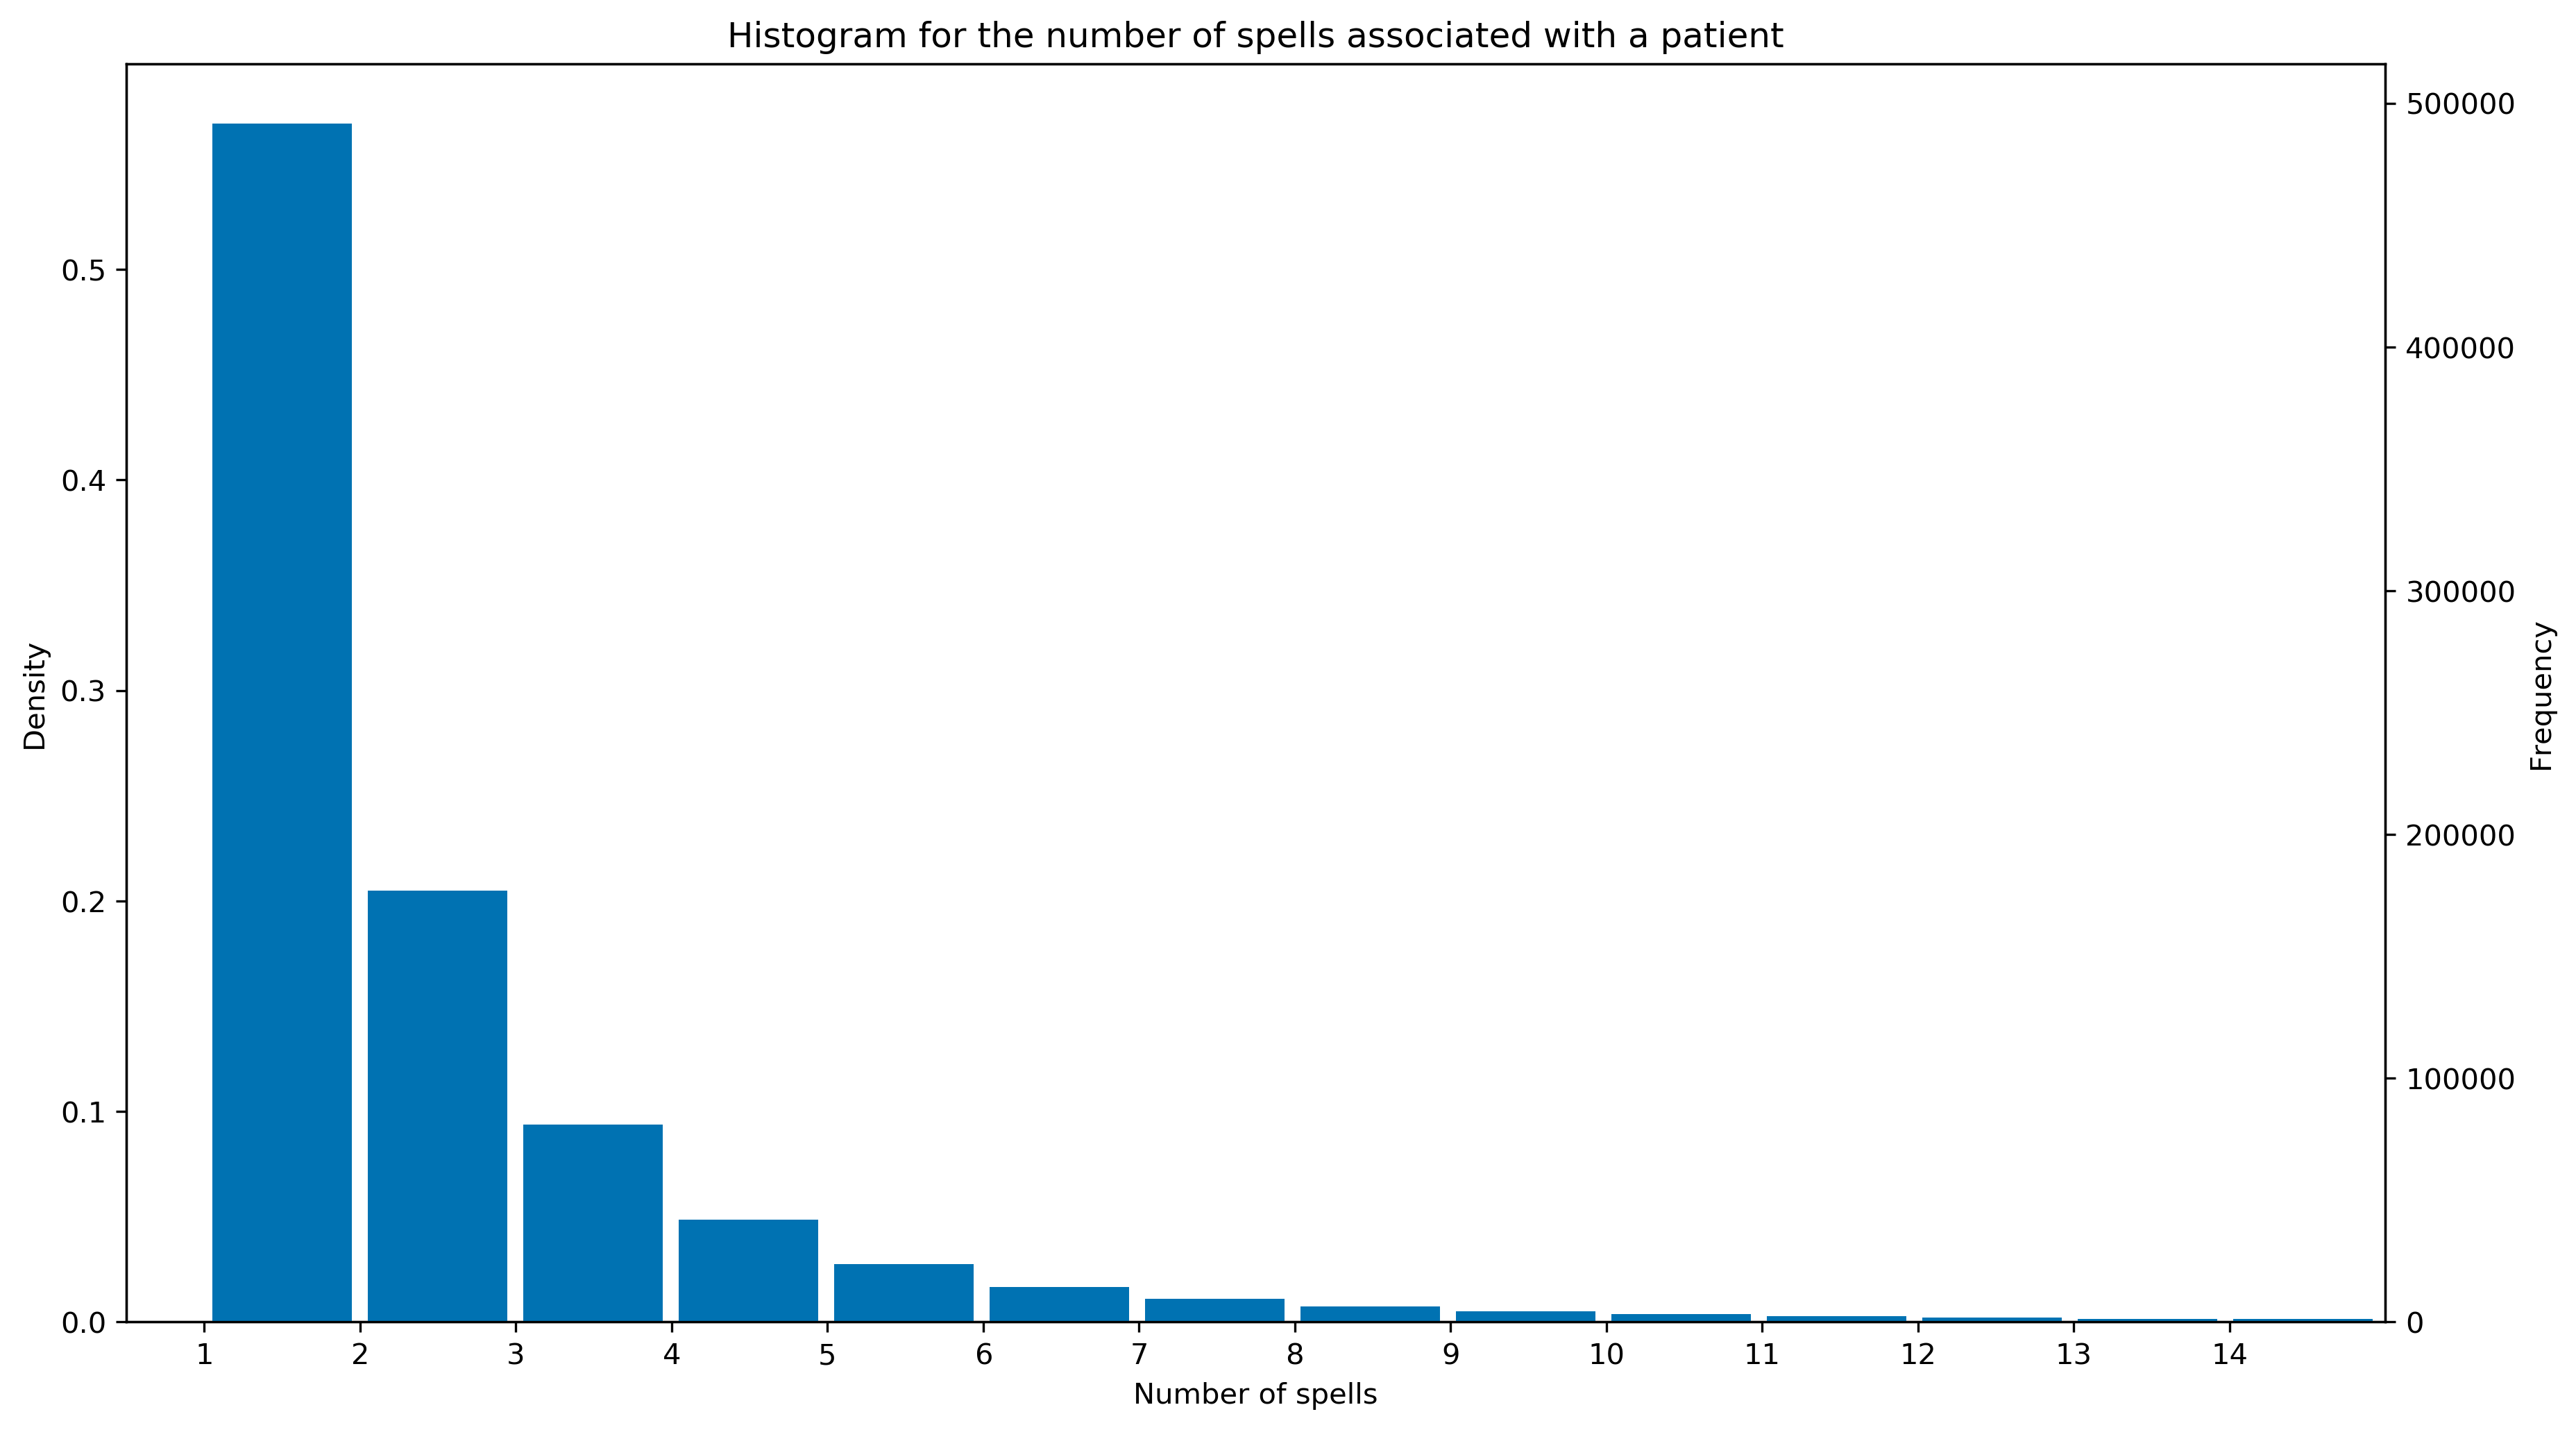

In [138]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

ax.hist(nspells, nspells.max(), rwidth=0.9, density=True)
ax2 = ax.twinx()
ax2.hist(nspells, nspells.max(), rwidth=0.9)

ax.set_ylabel('Density')
ax2.set_ylabel('Frequency')
ax.set_xlabel('Number of spells')

# minor_locs = MultipleLocator(0.05)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

ax.set_xlim(0.5, 15)
ax.set_xticks(np.arange(1, 15))

ax.set_title('Histogram for the number of spells associated with a patient')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/no_spells_hist.pdf');

In [ ]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(nspells, nspells.max(), rwidth=0.9)

# minor_locs = MultipleLocator(50000)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

# ax.set_xlim(0.5, 15)
# ax.set_xticks(np.arange(1, 15))
# ax.set_xlabel('Number of spells')
# ax.set_ylabel('Frequency')
# ax.set_title('Histogram for the total number of spells associated with a patient')

# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/no_spells_freq_hist.pdf');

In [ ]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(nspells, nspells.max(), rwidth=0.9, density=True)

# minor_locs = MultipleLocator(0.05)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')
# ax.set_xlim(0.5, 15)
# ax.set_xticks(np.arange(1, 15))
# ax.set_xlabel('Number of spells')
# ax.set_ylabel('Frequency density')
# ax.set_title('Density histogram for the total number of spells associated with a patient')

# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/no_spells_density_hist.pdf');

# Other clinical variables: diagnosis and procedure numbers

In [29]:
diagnosis_numbers = df.set_index('EPISODE_ID').DIAG_NO

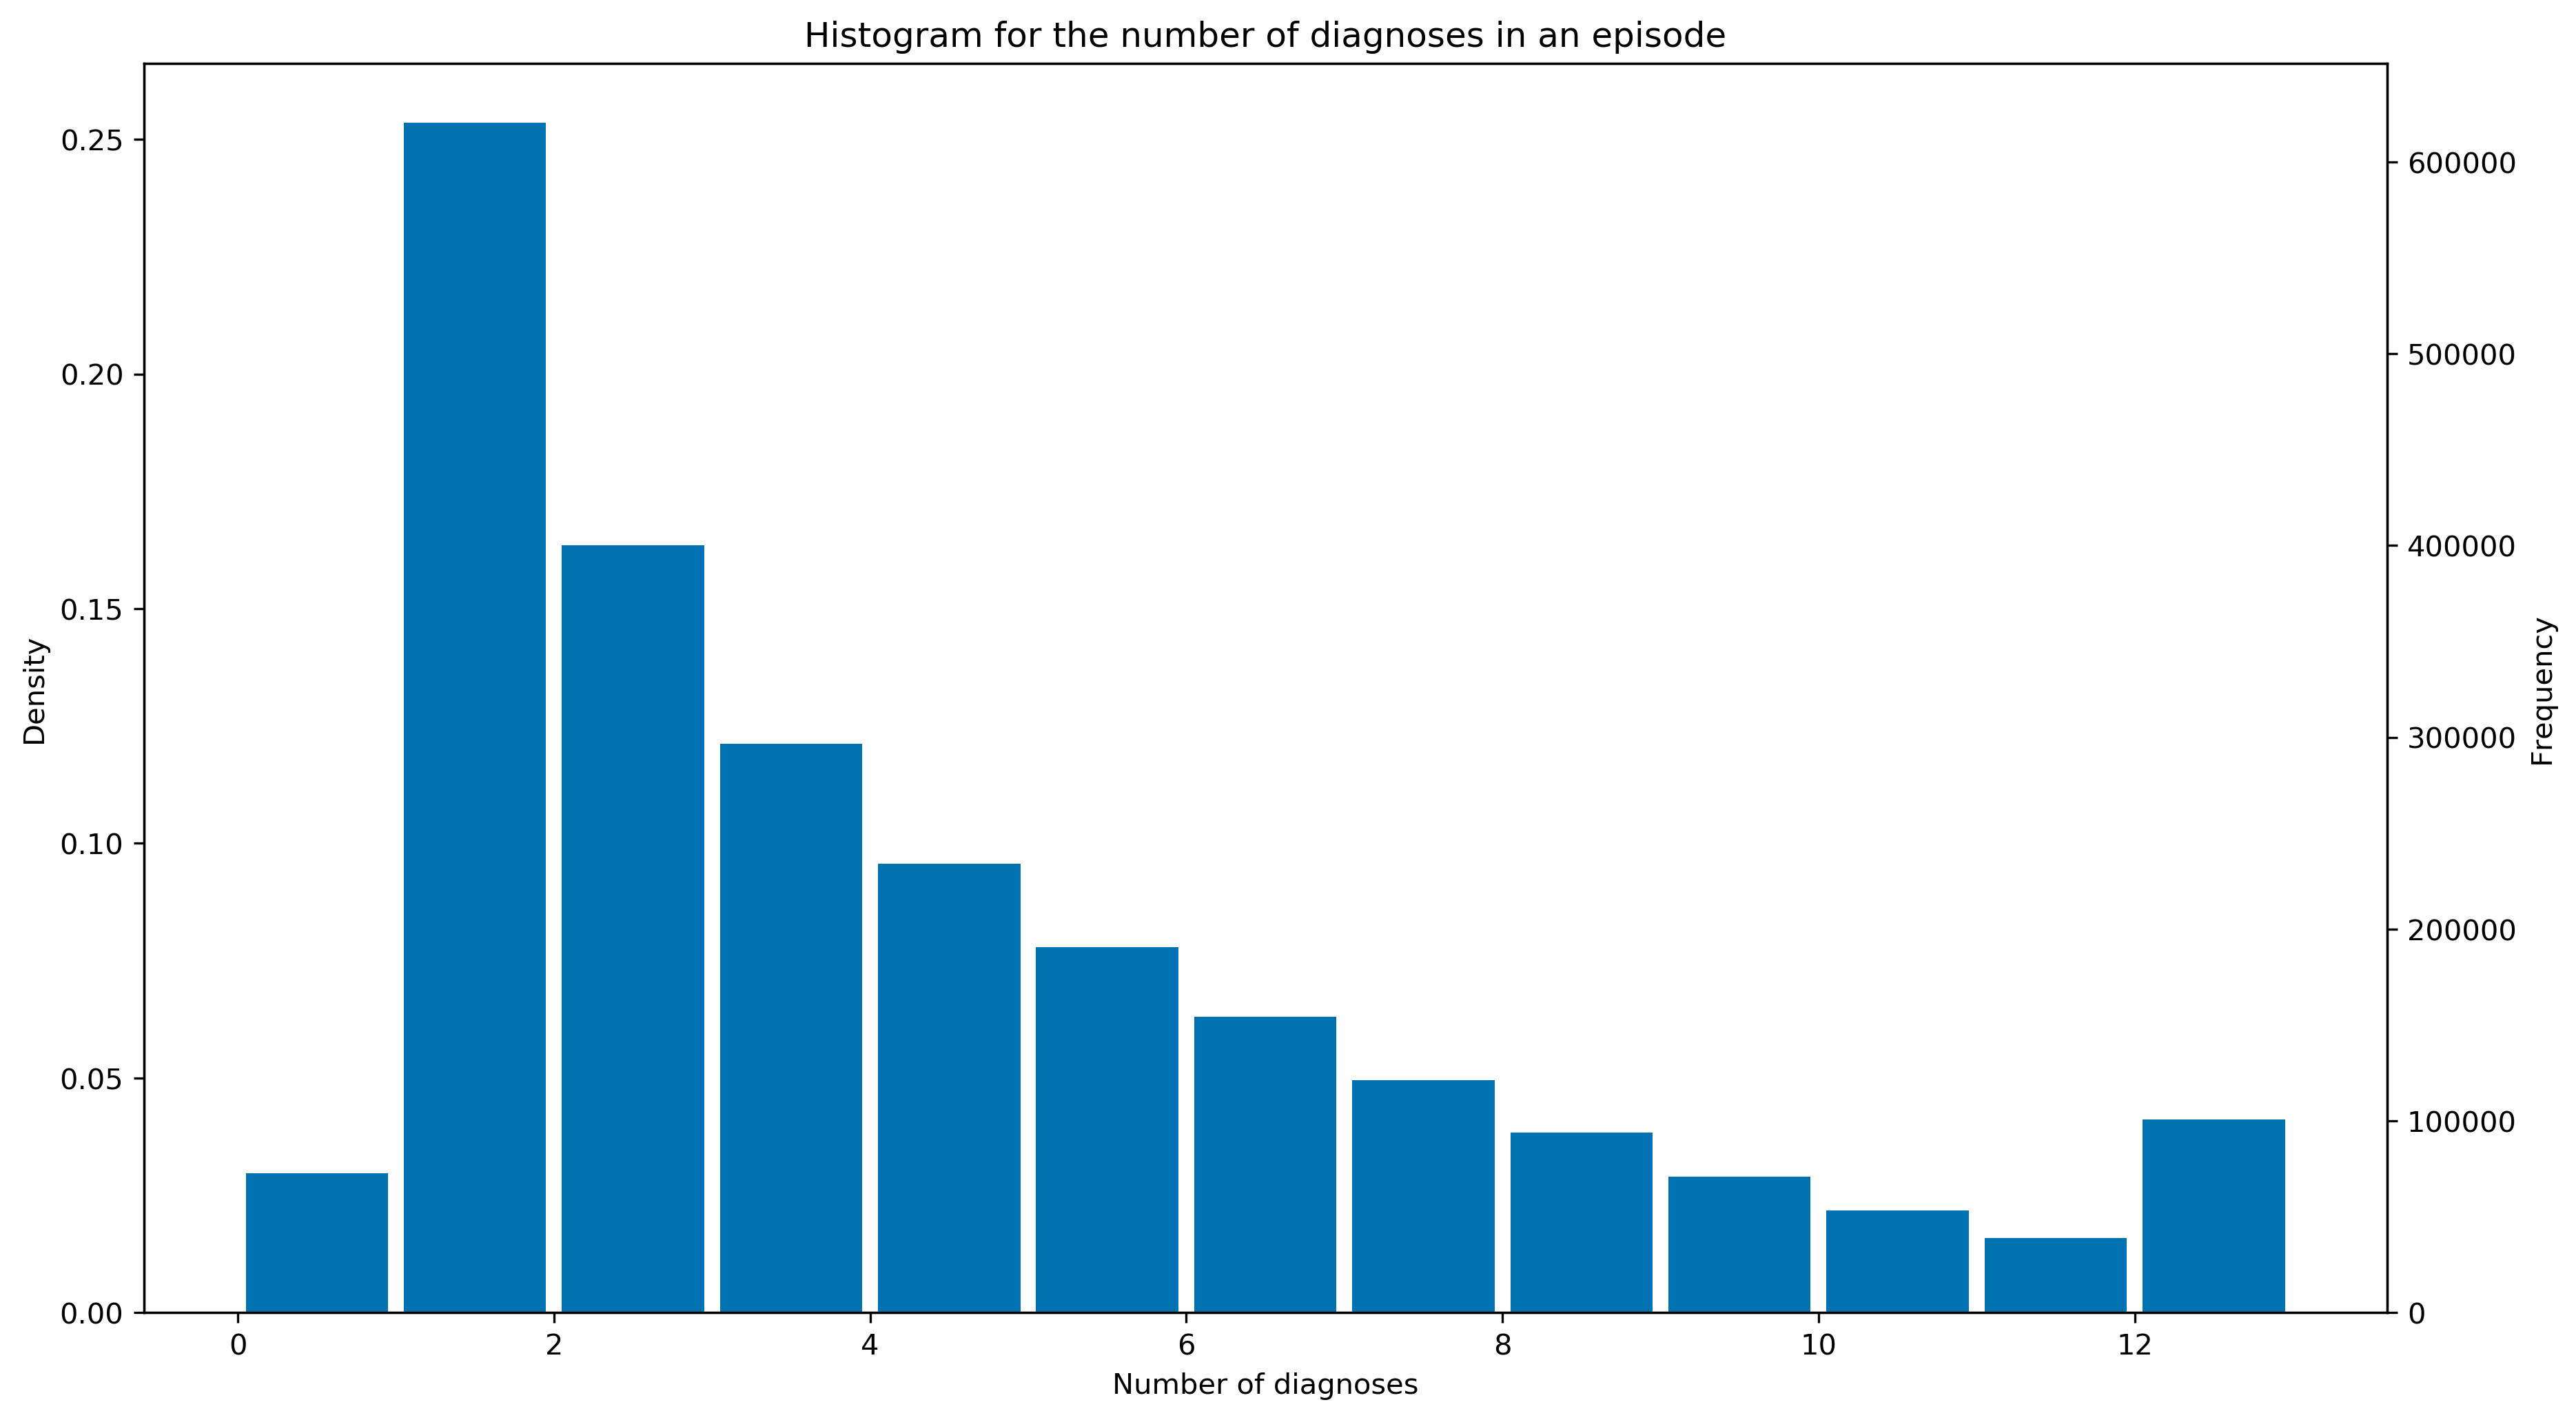

In [139]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

ax2 = ax.twinx()
ax.hist(diagnosis_numbers, diagnosis_numbers.max(), rwidth=0.9, density=True)
ax2.hist(diagnosis_numbers, diagnosis_numbers.max(), rwidth=0.9)

ax.set_ylabel('Density')
ax2.set_ylabel('Frequency')
ax.set_xlabel('Number of diagnoses')

# minor_locs = MultipleLocator(0.025)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

ax.set_title('Histogram for the number of diagnoses in an episode')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diag_no_hist.pdf');

In [146]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(diagnosis_numbers, diagnosis_numbers.max(), rwidth=0.9)

# ax.set_ylabel('Frequency density')
# ax.set_xlabel('Number of diagnoses')

# minor_locs = MultipleLocator(50000)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

# ax.set_title('Histogram for the number of diagnoses in an episode')
# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diag_no_freq_hist.pdf');

In [145]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(diagnosis_numbers, diagnosis_numbers.max(), rwidth=0.9, density=True)

# ax.set_ylabel('Frequency density')
# ax.set_xlabel('Number of diagnoses')

# minor_locs = MultipleLocator(0.025)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

# ax.set_title('Density histogram for the number of diagnoses in an episode')
# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diag_no_density_hist.pdf');

In [32]:
procedure_numbers = df.set_index('EPISODE_ID').PROC_NO

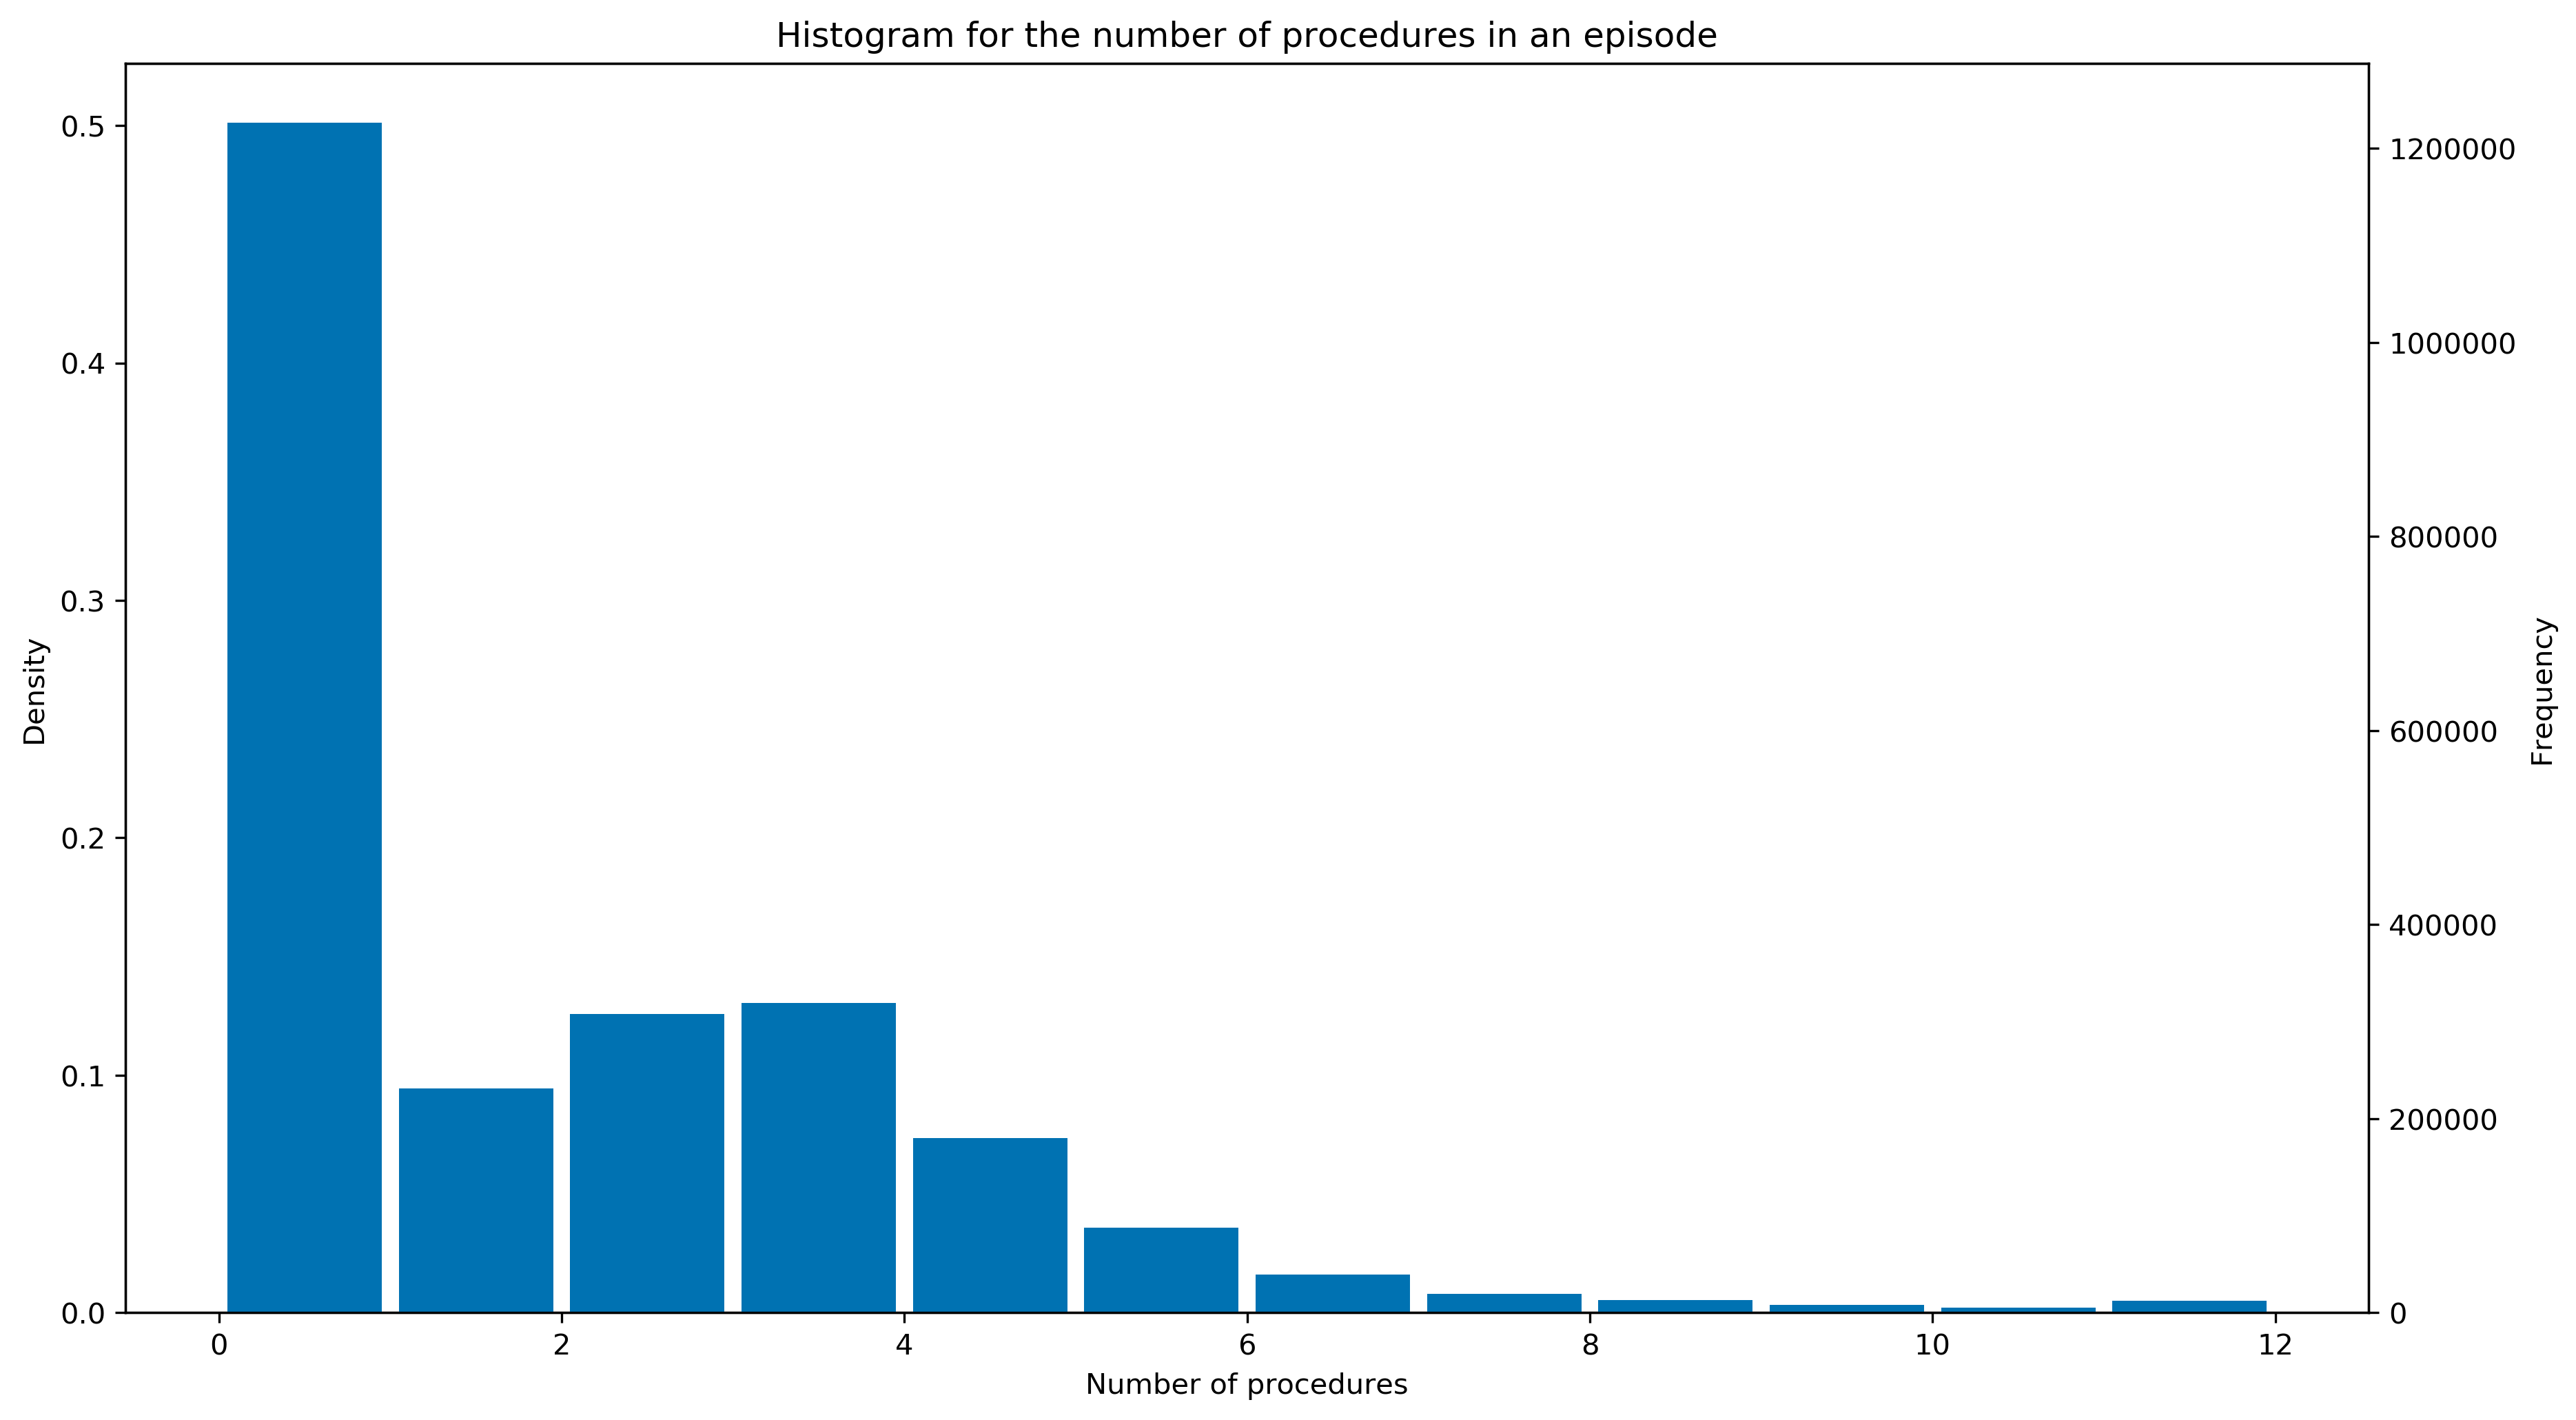

In [142]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

ax.hist(procedure_numbers, procedure_numbers.max(), rwidth=0.9, density=True)
ax2 = ax.twinx()
ax2.hist(procedure_numbers, procedure_numbers.max(), rwidth=0.9)

ax.set_ylabel('Density')
ax2.set_ylabel('Frequency')
ax.set_xlabel('Number of procedures')

# minor_locs = MultipleLocator(100000)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

ax.set_title('Histogram for the number of procedures in an episode')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/proc_no_hist.pdf');

In [143]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(procedure_numbers, procedure_numbers.max(), rwidth=0.9)

# ax.set_ylabel('Frequency')
# ax.set_xlabel('Number of procedures')

# minor_locs = MultipleLocator(100000)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

# ax.set_title('Histogram for the number of procedures in an episode')
# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/proc_no_freq_hist.pdf');

In [144]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(procedure_numbers, procedure_numbers.max(), rwidth=0.9, density=True)

# ax.set_ylabel('Frequency density')
# ax.set_xlabel('Number of procedures')

# minor_locs = MultipleLocator(0.05)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

# ax.set_title('Density histogram for the number of procedures in an episode')
# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/proc_no_density_hist.pdf');

# Cost components: contribution, correlation and variation
---

Our objective is to better understand cost variation in our data, so let us focus our analysis on that for now. We begin by determining the components of costs with the highest variation.

- Coefficient of variation is a standardised measure
- Use this as a model for regression to understand what makes the variation

In [70]:
costs = [
    'COST', 'NetCost', 'DRUG', 'ENDO', 'HCD', 'EMER', 'CRIT',
    'IMG', 'IMG_OTH', 'MED', 'NCI', 'NID', 'OCLST', 'OPTH',
    'OTH', 'OTH_OTH', 'OUTP', 'OVH', 'PATH', 'PATH_OTH',
    'PHAR', 'PROS', 'RADTH', 'SECC', 'SPS', 'THER', 'WARD'
]

## Cost component variation

We collect the total of all cost variables in a spell, i.e. the total cost of each episode in every spell, and then find the coefficient of variation for each component in the population of patient spells.

In [153]:
sum_costs = df.groupby(['SPELL_ID'])[[c for c in costs if c not in ['NetCost', 'COST']]].sum()

variations = (sum_costs.std() / sum_costs.mean())
variations.sort_values(ascending=False, inplace=True)

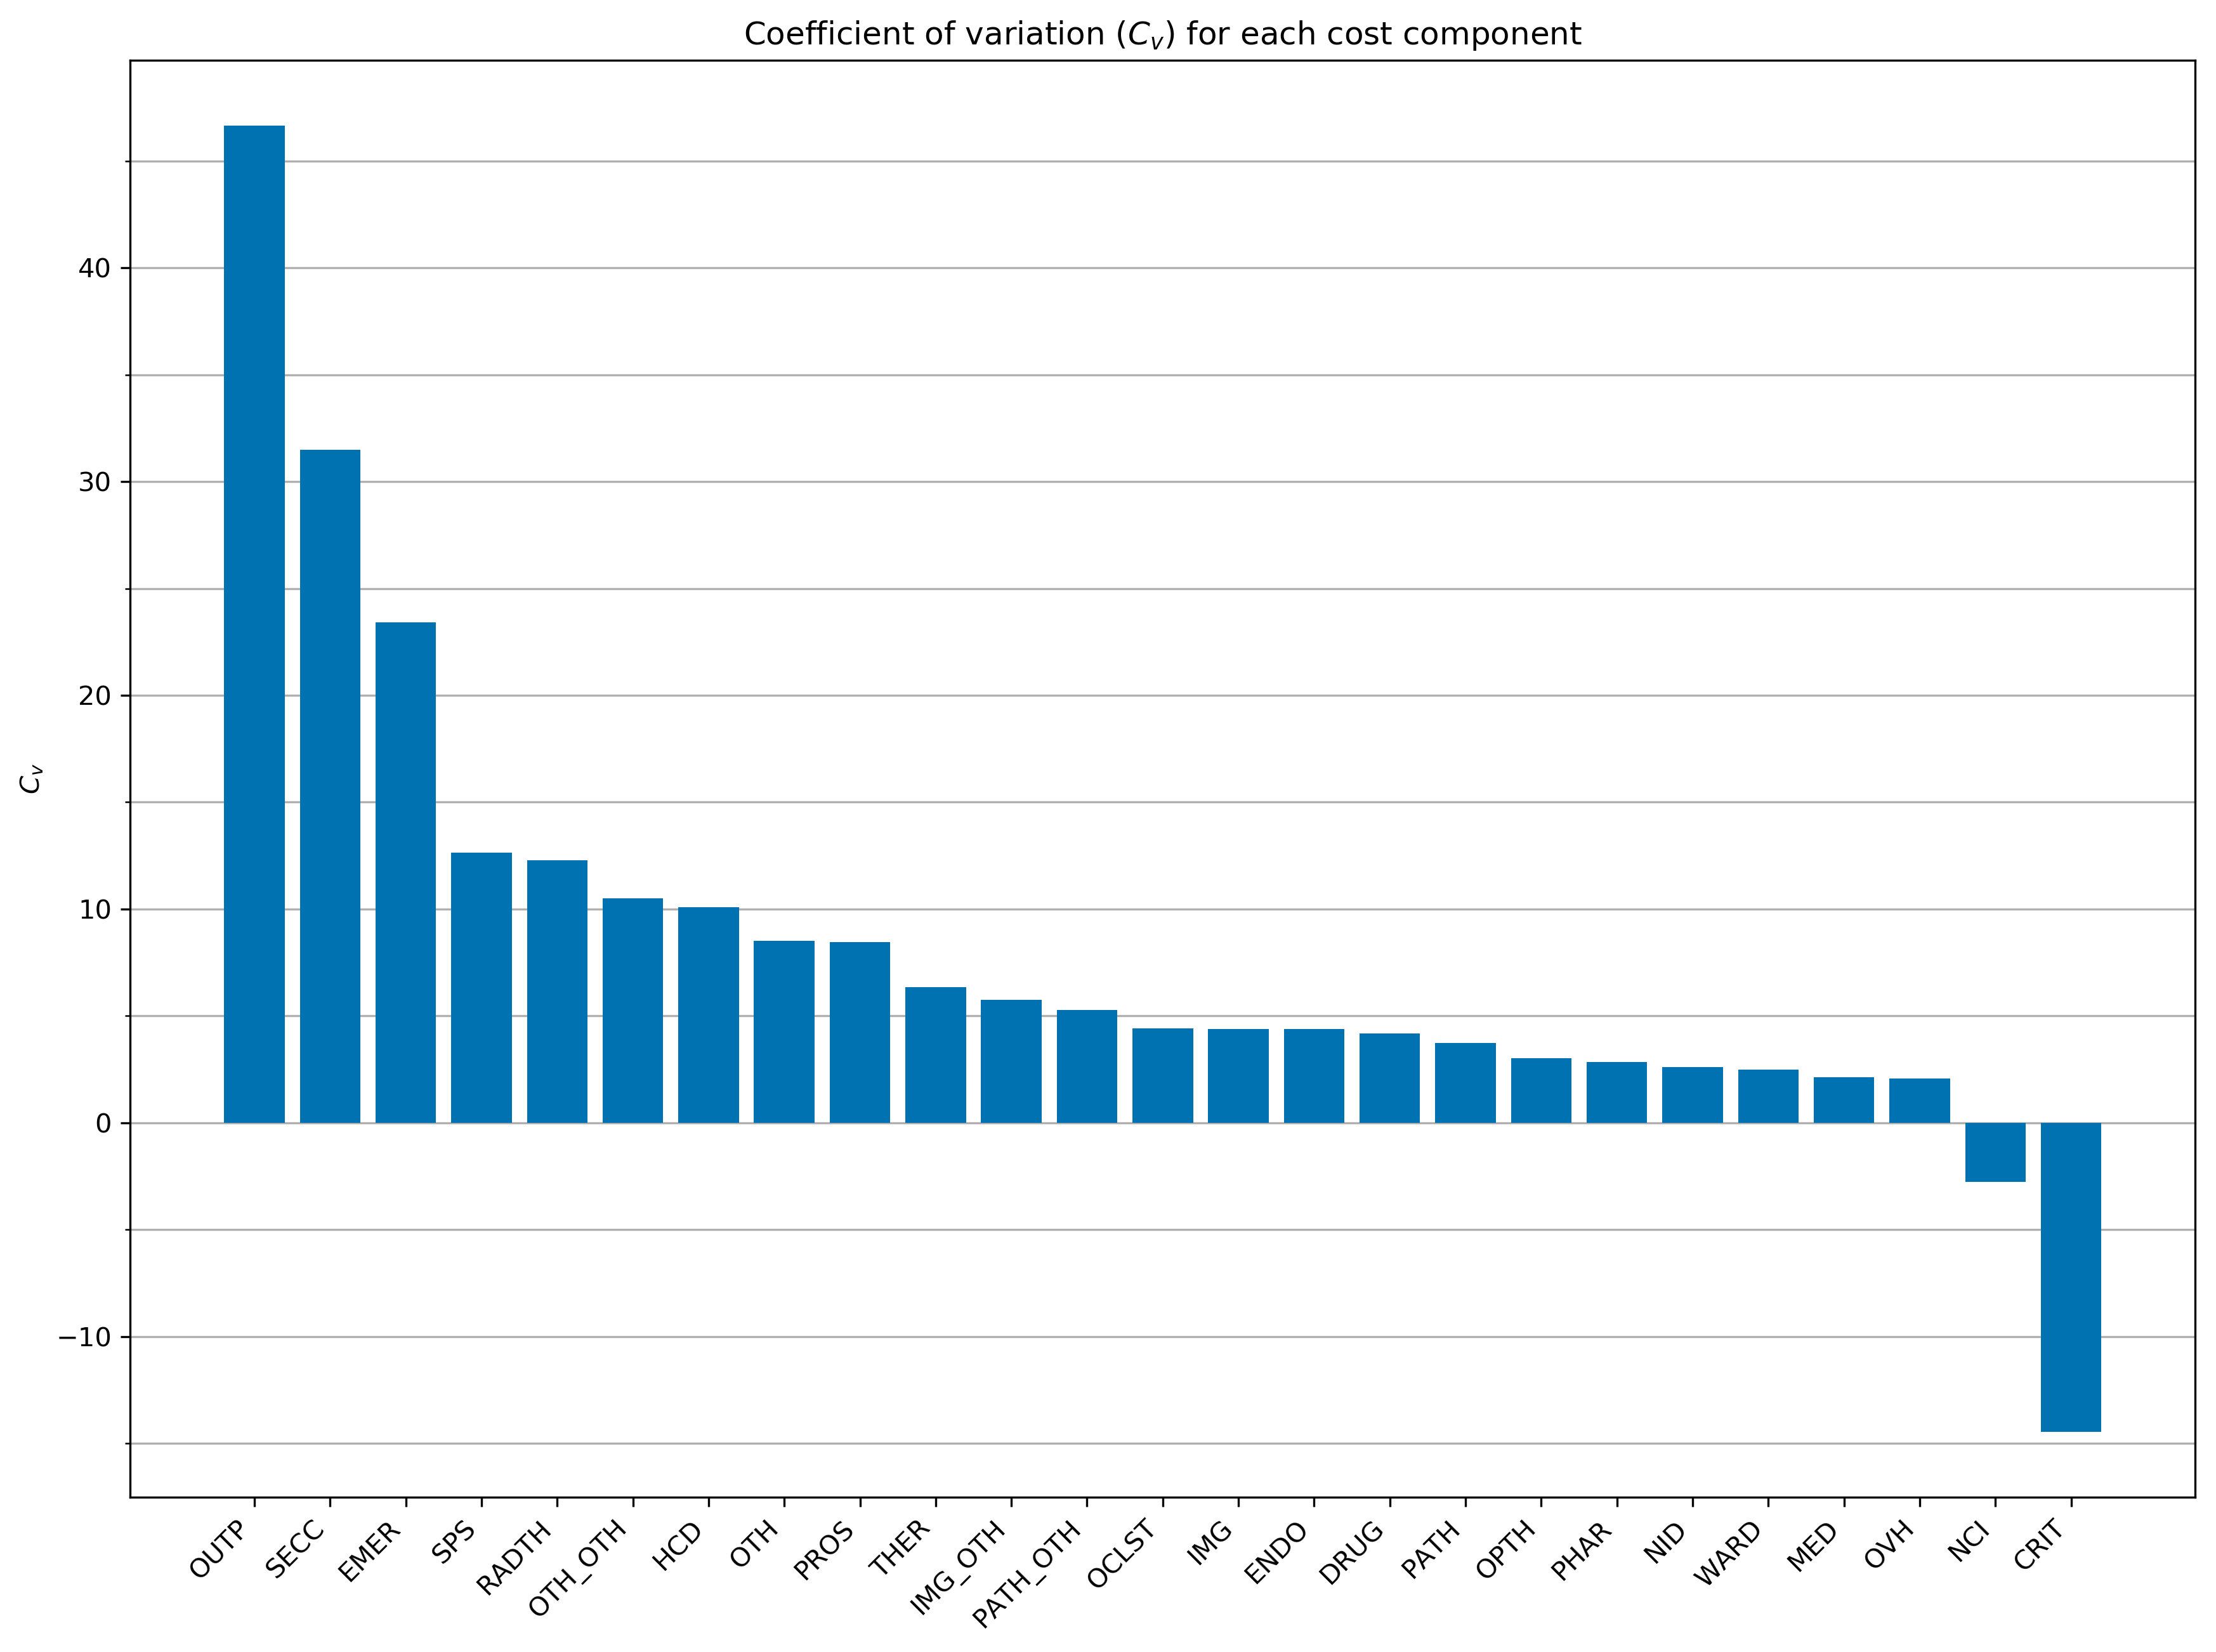

In [154]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

ax.bar(variations.index, variations.values)

ax.set_title(r'Coefficient of variation ($C_v$) for each cost component')
ax.set_ylabel(r'$C_v$')

minor_locs = MultipleLocator(5)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/coeff_variation.pdf');

## Cost component proportions

In [149]:
proportions = sum_costs[[c for c in costs if c not in ['COST', 'NetCost']]].divide(sum_costs['NetCost'], axis=0)

mean_props = proportions.mean().sort_values(ascending=False)

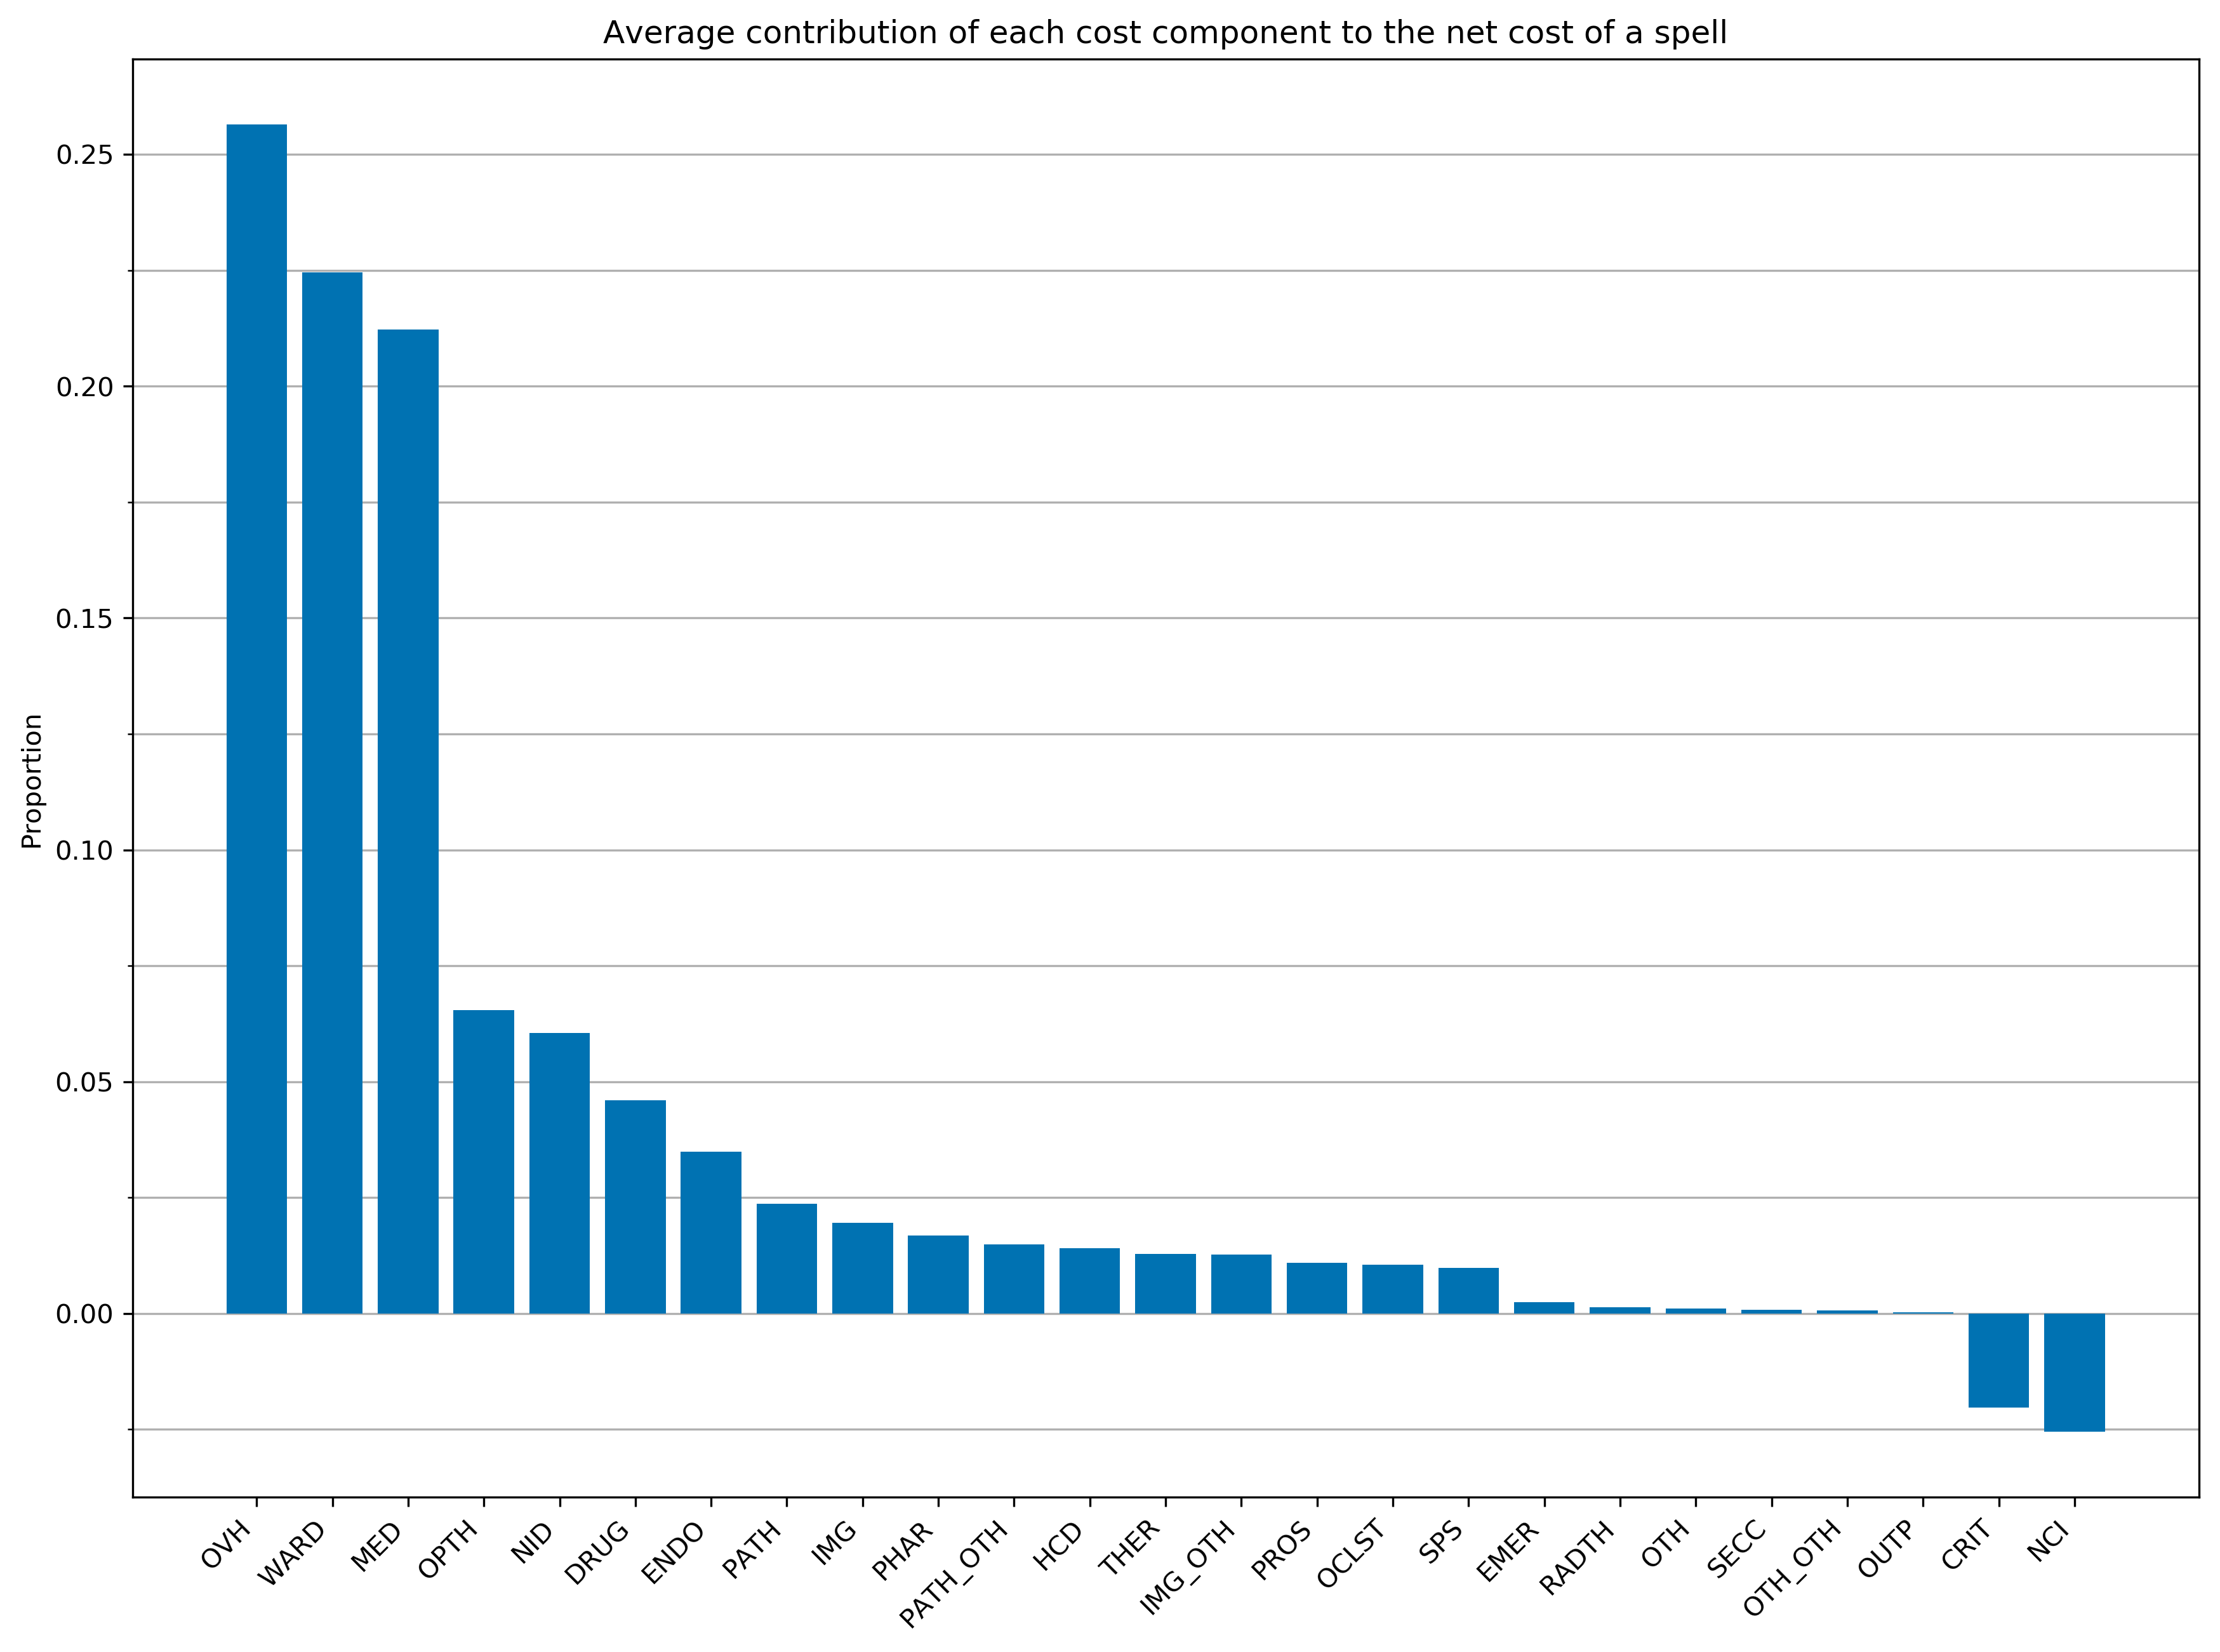

In [150]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

xs = np.arange(len(mean_props))
ax.bar(mean_props.index, mean_props.values)

ax.set_ylabel('Proportion')

minor_locs = MultipleLocator(0.025)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

ax.set_title('Average contribution of each cost component to the net cost of a spell')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/cost_contribution.pdf');

## Contribution vs. variation

In [162]:
cont_var_df = pd.concat([mean_props, variations], axis=1).rename({0: 'proportion', 1: 'variation'}, axis=1)

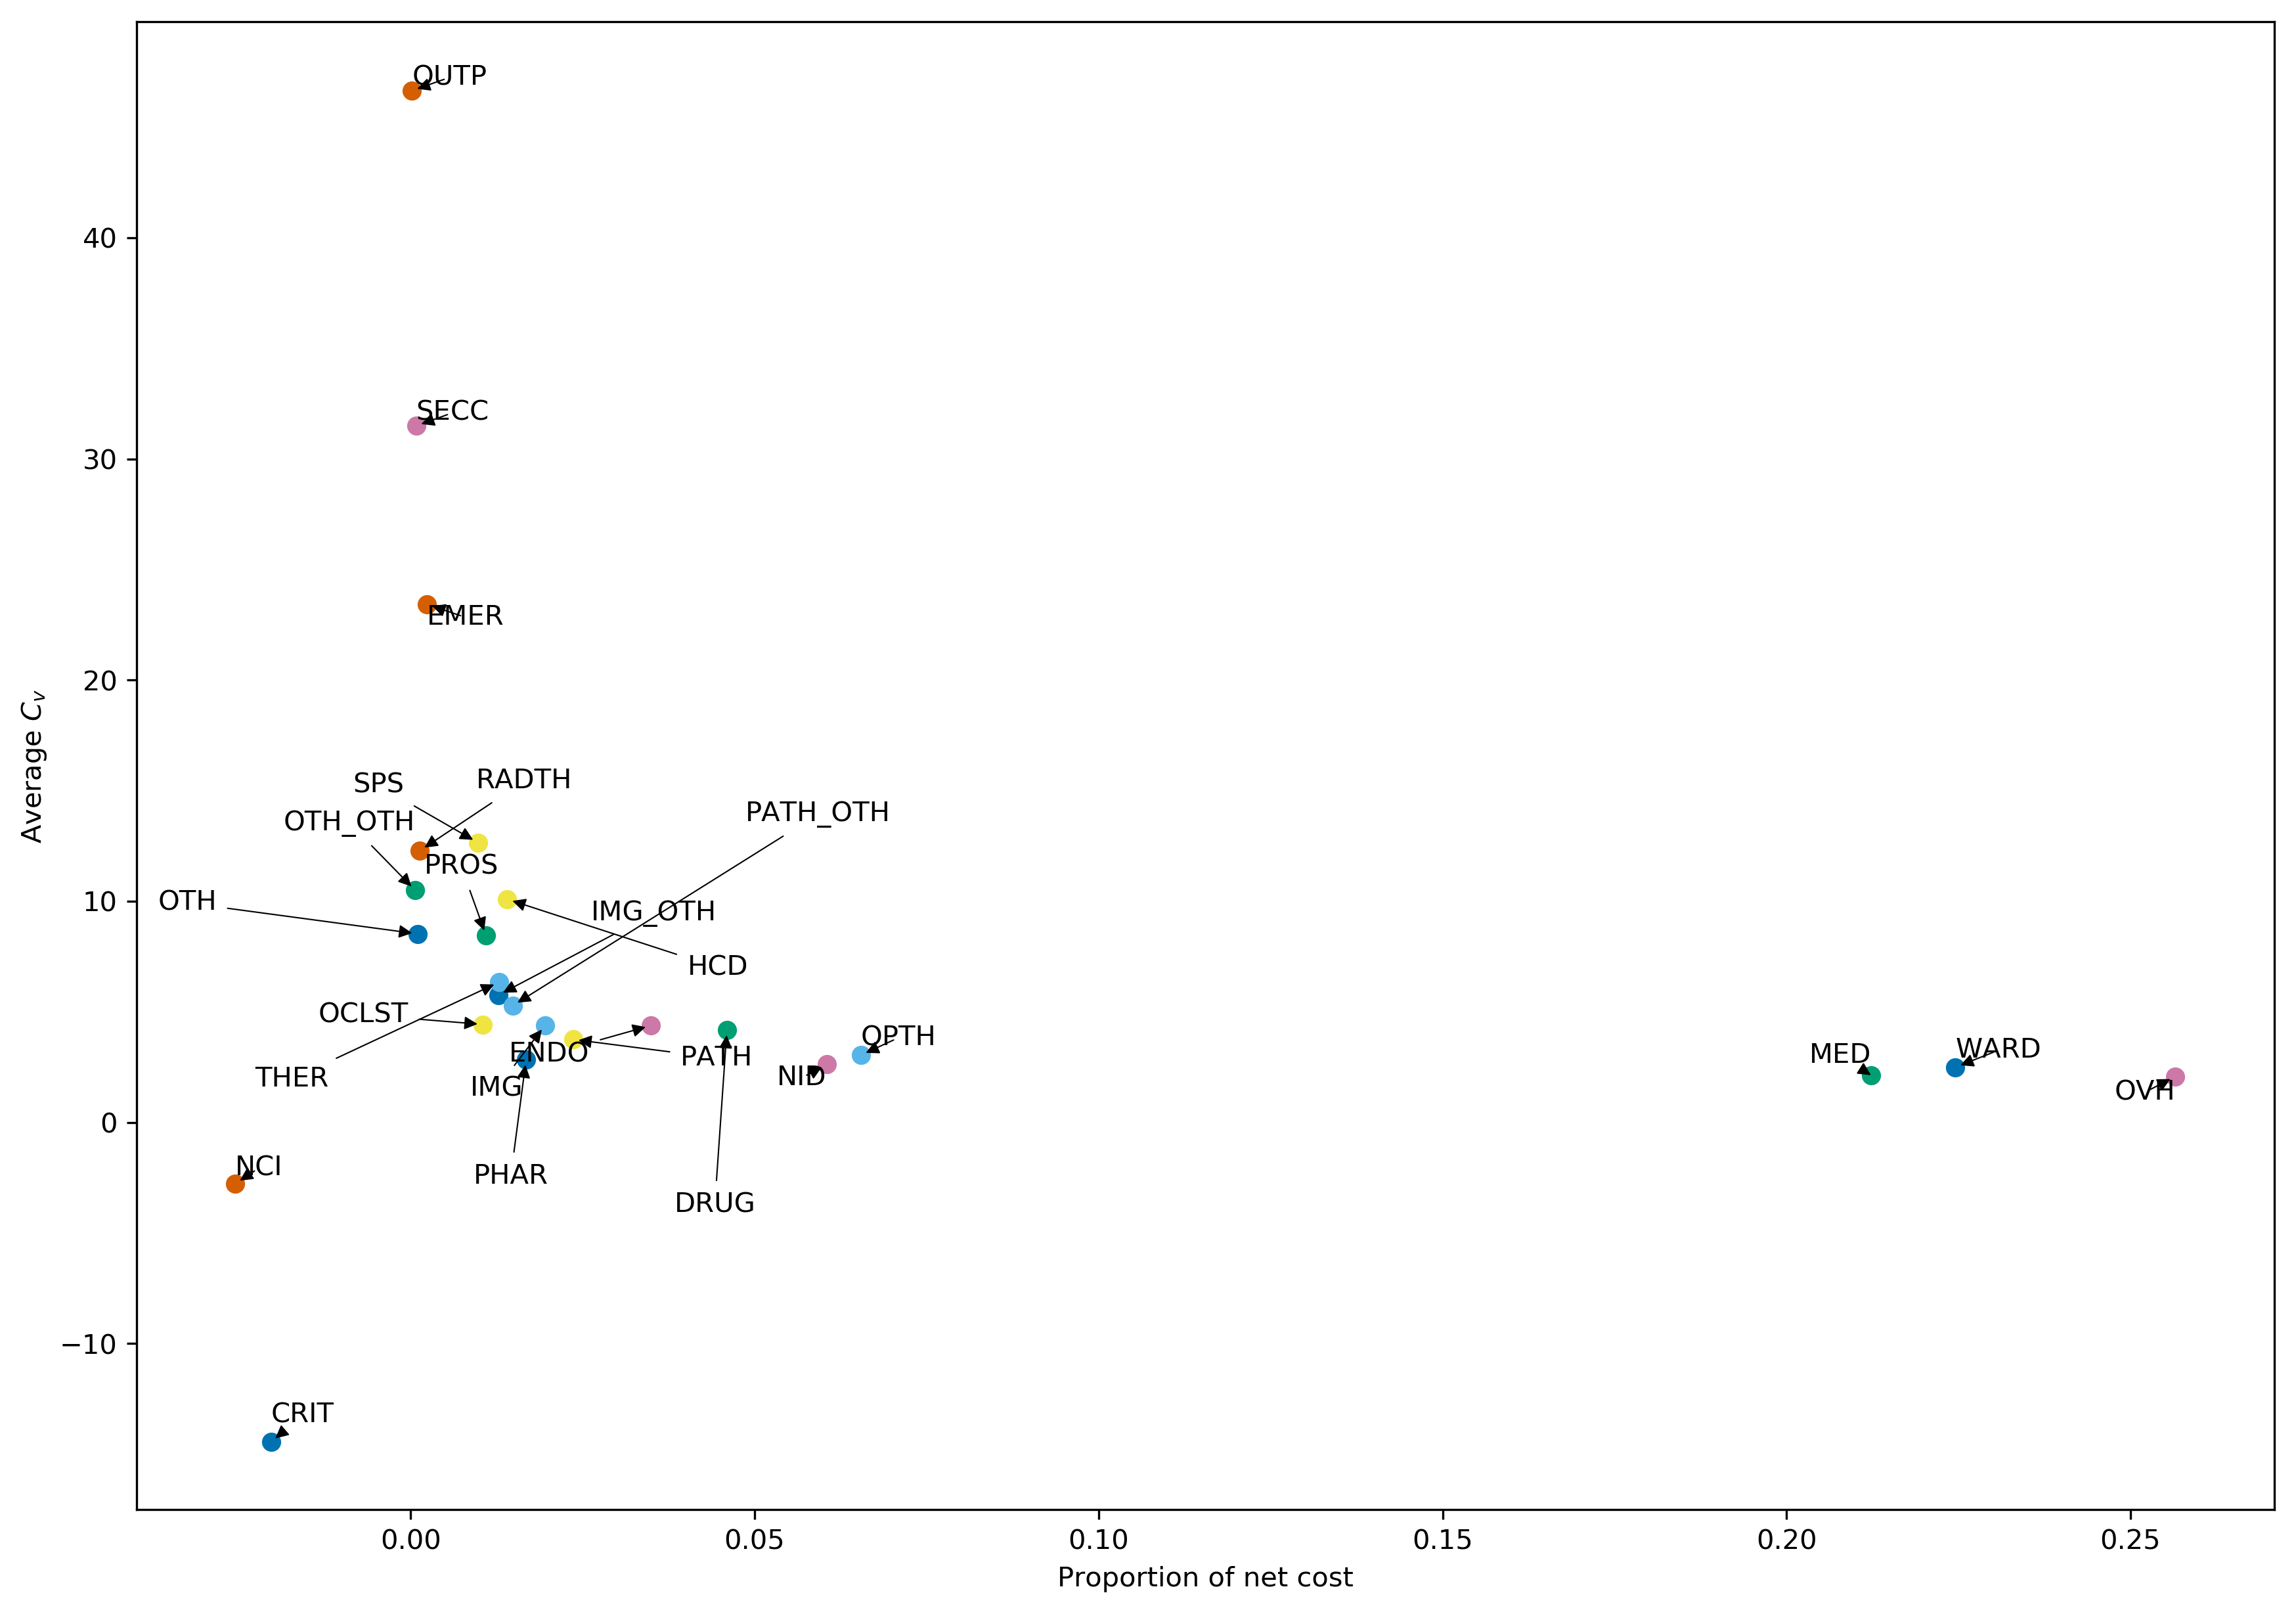

In [219]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

interp = interp1d(cont_var_df['proportion'], cont_var_df['variation'])
xs = np.arange(cont_var_df['proportion'].min(), cont_var_df['proportion'].max(), 0.005)
ys = interp(xs)

texts = []
for point in cont_var_df.iterrows():
    ax.scatter(
        *point[1], label=point[0]
    )
    texts.append(
        ax.text(*point[1], point[0],
        horizontalalignment='right',
        verticalalignment='top')
    )

adjust_text(texts, x=xs, y=ys, force_text=2.5,
            only_move={'points': 'y', 'text': 'xy'}, 
            arrowprops=dict(arrowstyle="-|>", color='k', lw=0.5))
ax.grid(b=True, which='minor', axis='y')
ax.set_xlabel('Proportion of net cost')
ax.set_ylabel(r'Average $C_v$')
fig.savefig('/Users/henrywilde/repos/talks/data-analysis/img/contribution_variation.pdf');

## Correlation

In [72]:
true_lengths = df.groupby('SPELL_ID').TRUE_LOS.mean()
diag_proc = df.groupby('SPELL_ID')[['DIAG_NO', 'PROC_NO']].max()

data = pd.concat([sum_costs, true_lengths, diag_proc], axis=1)

In [73]:
correlation = data.corr().round(2)

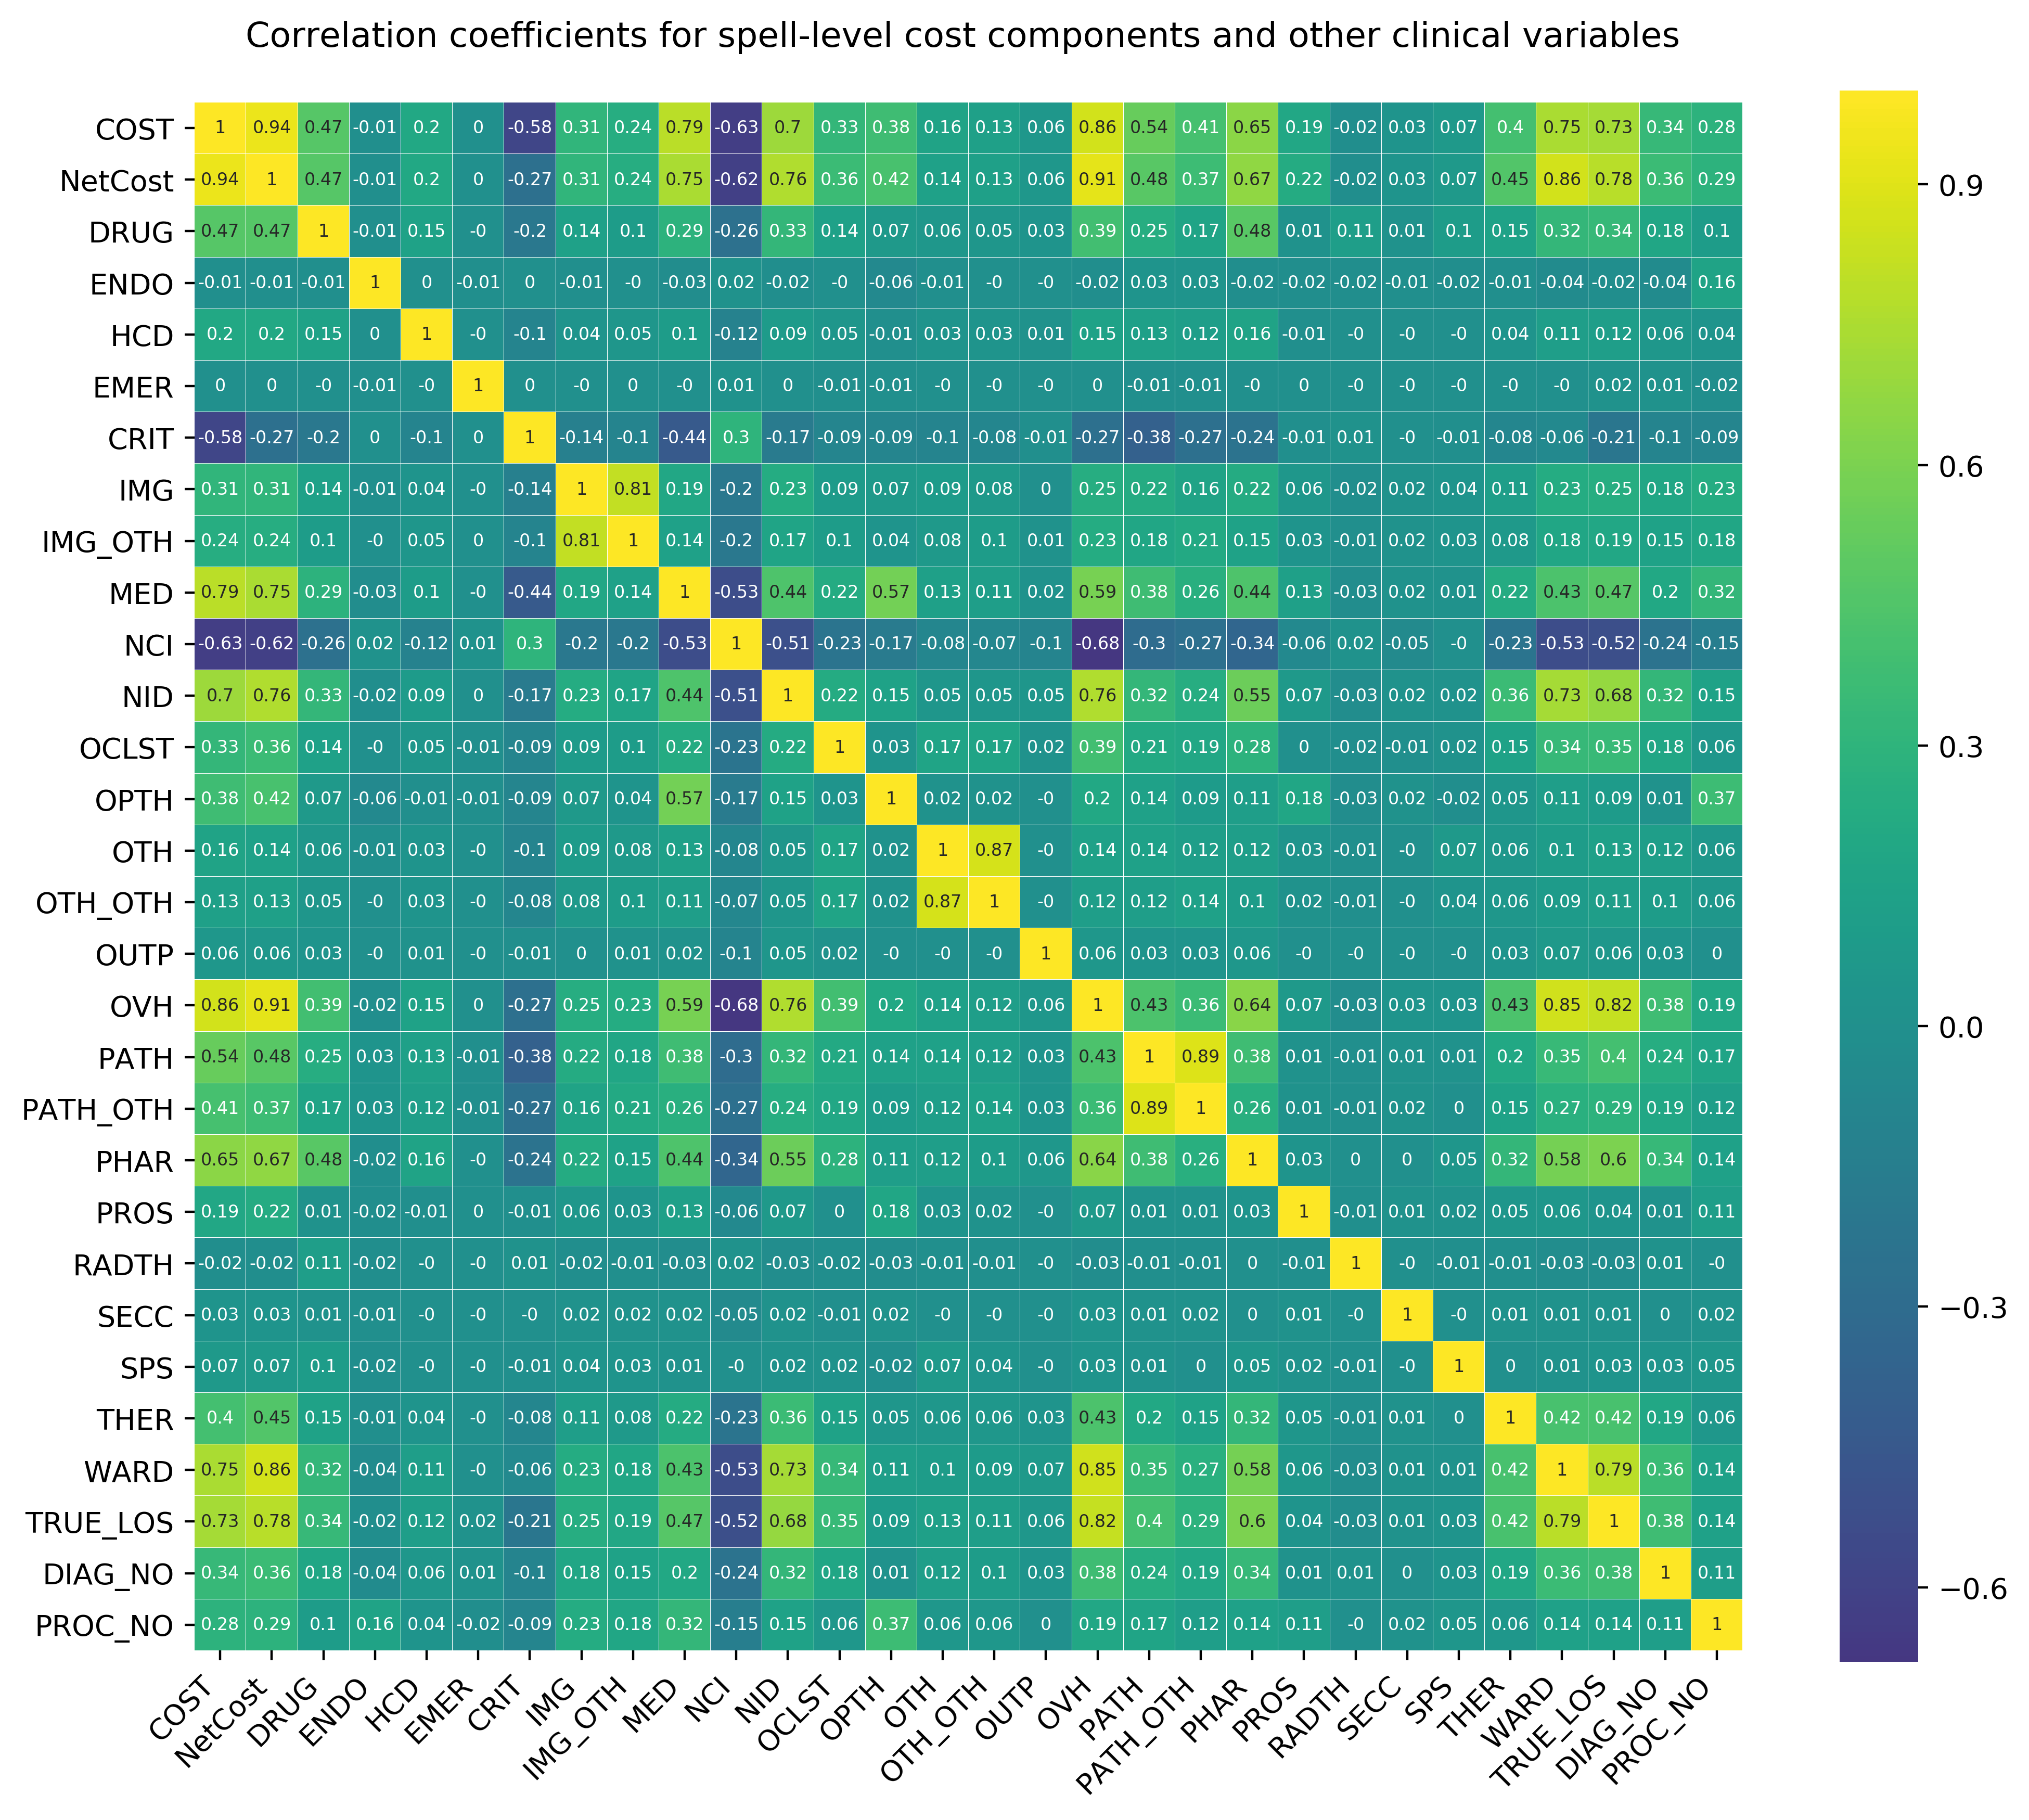

In [74]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=400)

sbn.heatmap(correlation, square=True, cmap='viridis', center=0,
            linewidths=0.01, annot=True, annot_kws={'fontsize': 6}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

ax.set_title('Correlation coefficients for spell-level cost components and other clinical variables \n')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/corr_heatmap.pdf', transparent=True);

## Net cost distribution

Taking this trim **(no longer done as not needed)** is not necessarily that useful. Sure, if you take a tail off you get a "nicer" distribution and people cost less on the whole. What would be better is to incorporate the carbon-copy stories and say these two very similar people are far apart (one in the tail, the other in the nose) but if you changed this thing about them you could move that person person in the tail up. Thus, saving potentially £1000s.

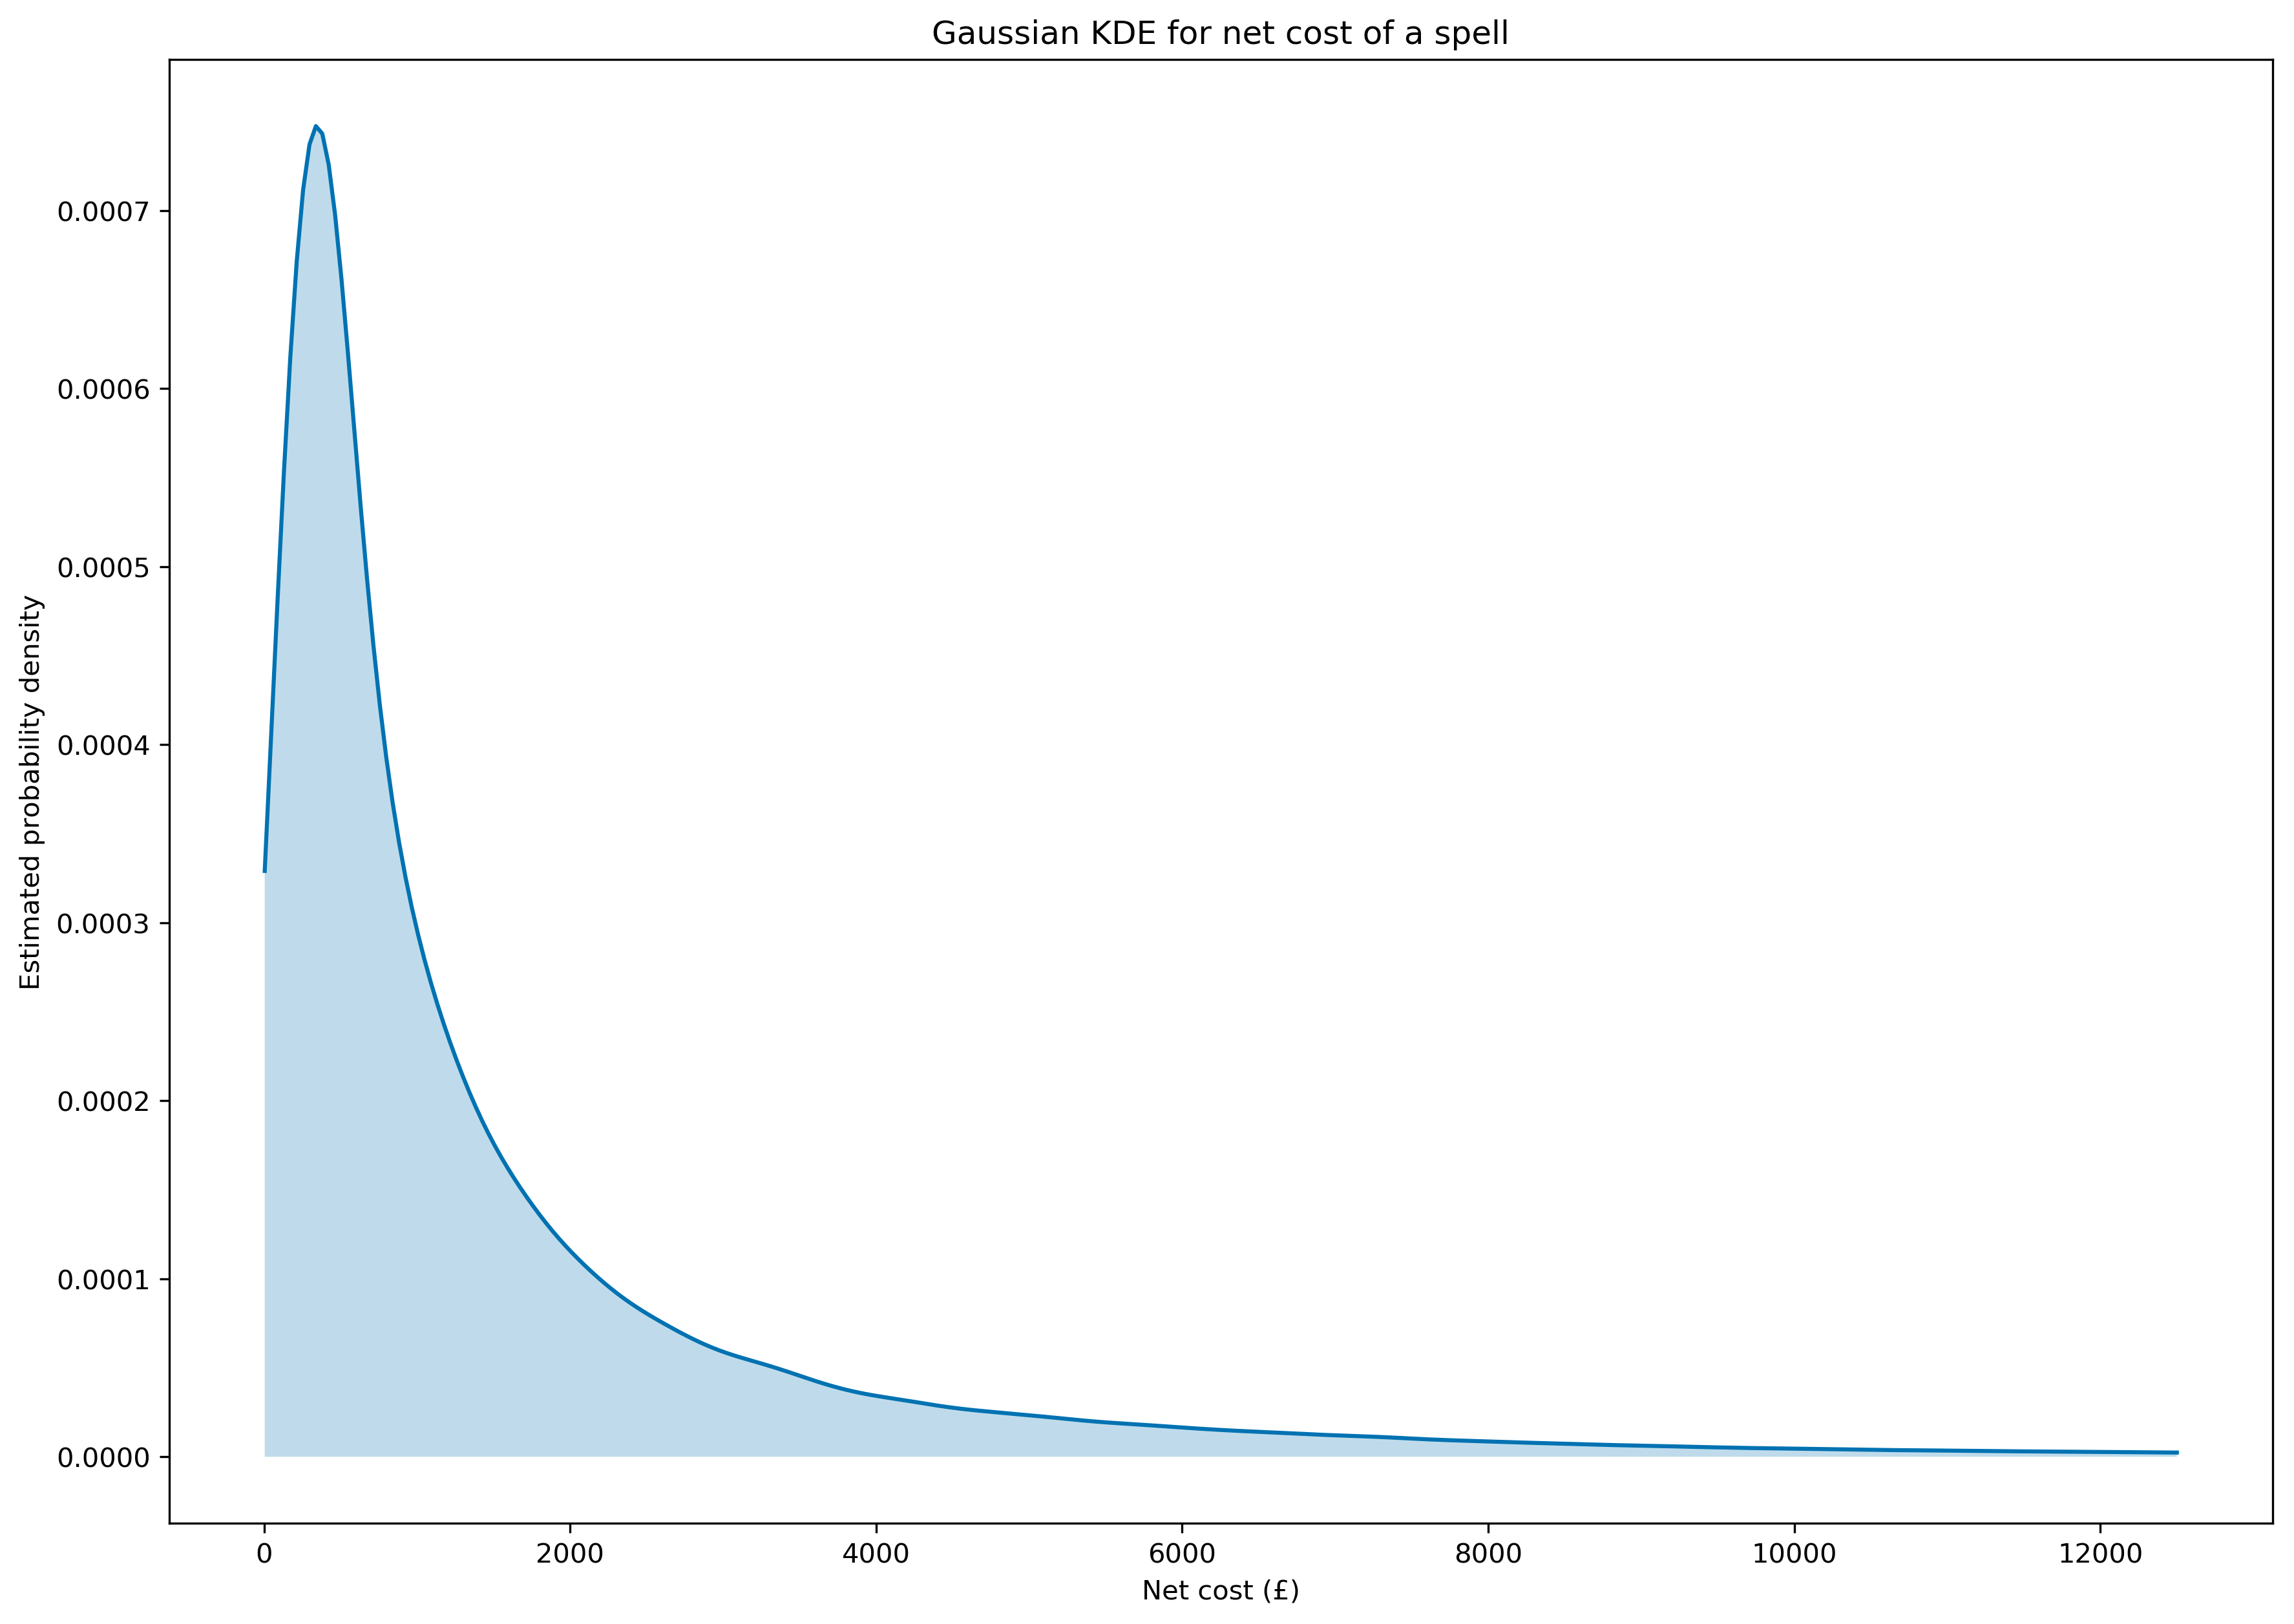

In [148]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

data = sum_costs['NetCost']
steps = 300
xs = np.linspace(data.min(), 12500, steps)
density = gaussian_kde(data)

ax.plot(xs, density(xs))
ax.fill_between(xs, [0]*steps, density(xs), alpha=0.25)

ax.set_xlabel('Net cost (£)')
ax.set_ylabel('Estimated probability density')
ax.set_title('Gaussian KDE for net cost of a spell')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/netcost_kde.pdf');

## LOS distribution

One of the largest contributors to the net cost of treating someone is the cost of keeping them in the hospital. These are recorded most clearly in the ward and overheads cost components. As such, investigating length of stay (LOS) as a measure of resources used by patients could prove fruitful.

In [220]:
general_LOS = df[time_constraint].set_index('ADMDATE') \
                                 .drop_duplicates('SPELL_ID')['TRUE_LOS']

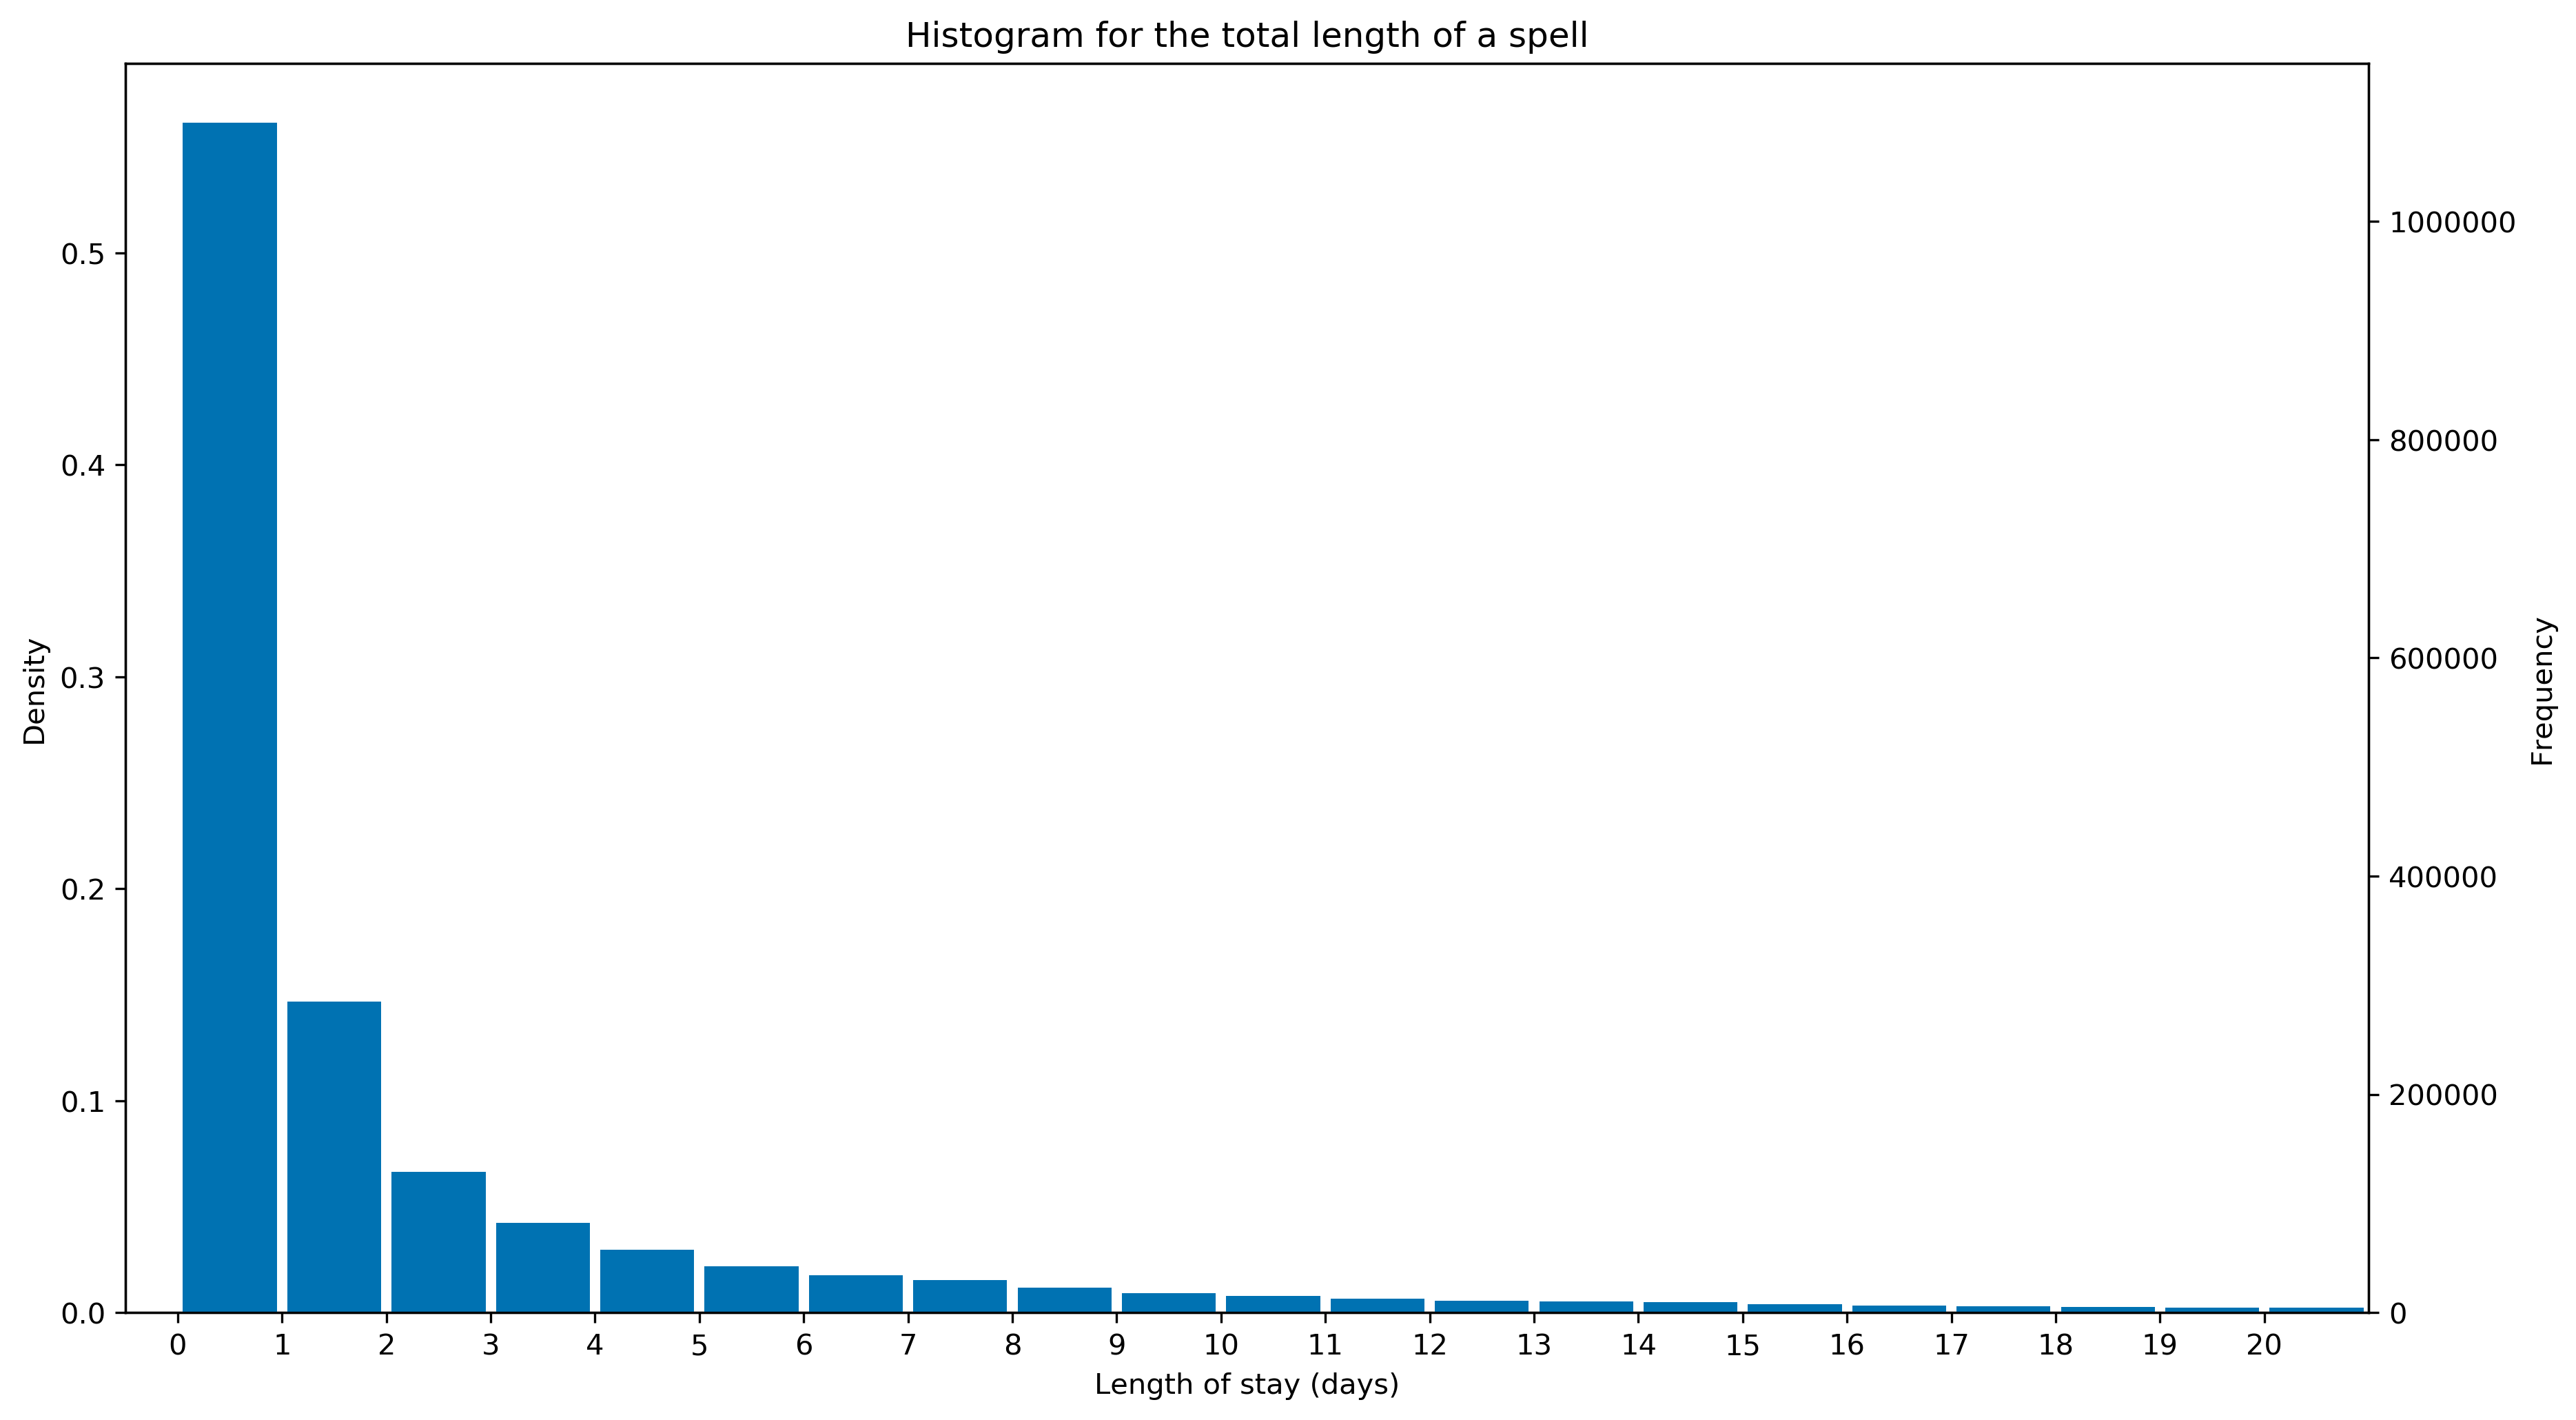

In [223]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

ax.hist(general_LOS, int(general_LOS.max()), rwidth=0.9, density=True)
ax2 = ax.twinx()
ax2.hist(general_LOS, int(general_LOS.max()), rwidth=0.9)

# minor_locs = MultipleLocator(100000)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

ax.set_xlim(-0.5, 21)
ax.set_xticks(np.arange(21))
ax.set_xlabel('Length of stay (days)')
ax.set_ylabel('Density')
ax2.set_ylabel('Frequency')
ax.set_title('Histogram for the total length of a spell')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/LOS_hist.pdf');

In [224]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(general_LOS, int(general_LOS.max()), rwidth=0.9)

# minor_locs = MultipleLocator(100000)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

# ax.set_xlim(-0.5, 21)
# ax.set_xticks(np.arange(21))
# ax.set_xlabel('Length of stay (days)')
# ax.set_ylabel('Frequency')
# ax.set_title('Histogram for the total length of a spell')

# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/LOS_freq_hist.pdf');

In [225]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(general_LOS, int(general_LOS.max()), rwidth=0.9, density=True)

# minor_locs = MultipleLocator(0.05)
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

# ax.set_xlim(-0.5, 21)
# ax.set_xticks(np.arange(21))
# ax.set_xlabel('Length of stay (days)')
# ax.set_ylabel('Frequency density')
# ax.set_title('Density histogram for the total length of a spell')

# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/LOS_density_hist.pdf');

# Demographic analysis
---

It is useful to get an understanding of the demographics that make up our dataset.

## Age distribution

In the figure below we plot a histogram displaying the distribution of the ages of the patients in our dataset. This is done irrespective of spell or any other variable; the only altering is that repeated ages for patients (several episode records in the same spell) are dropped.

In [227]:
ages = df.drop_duplicates('SPELL_ID').Age.dropna().values

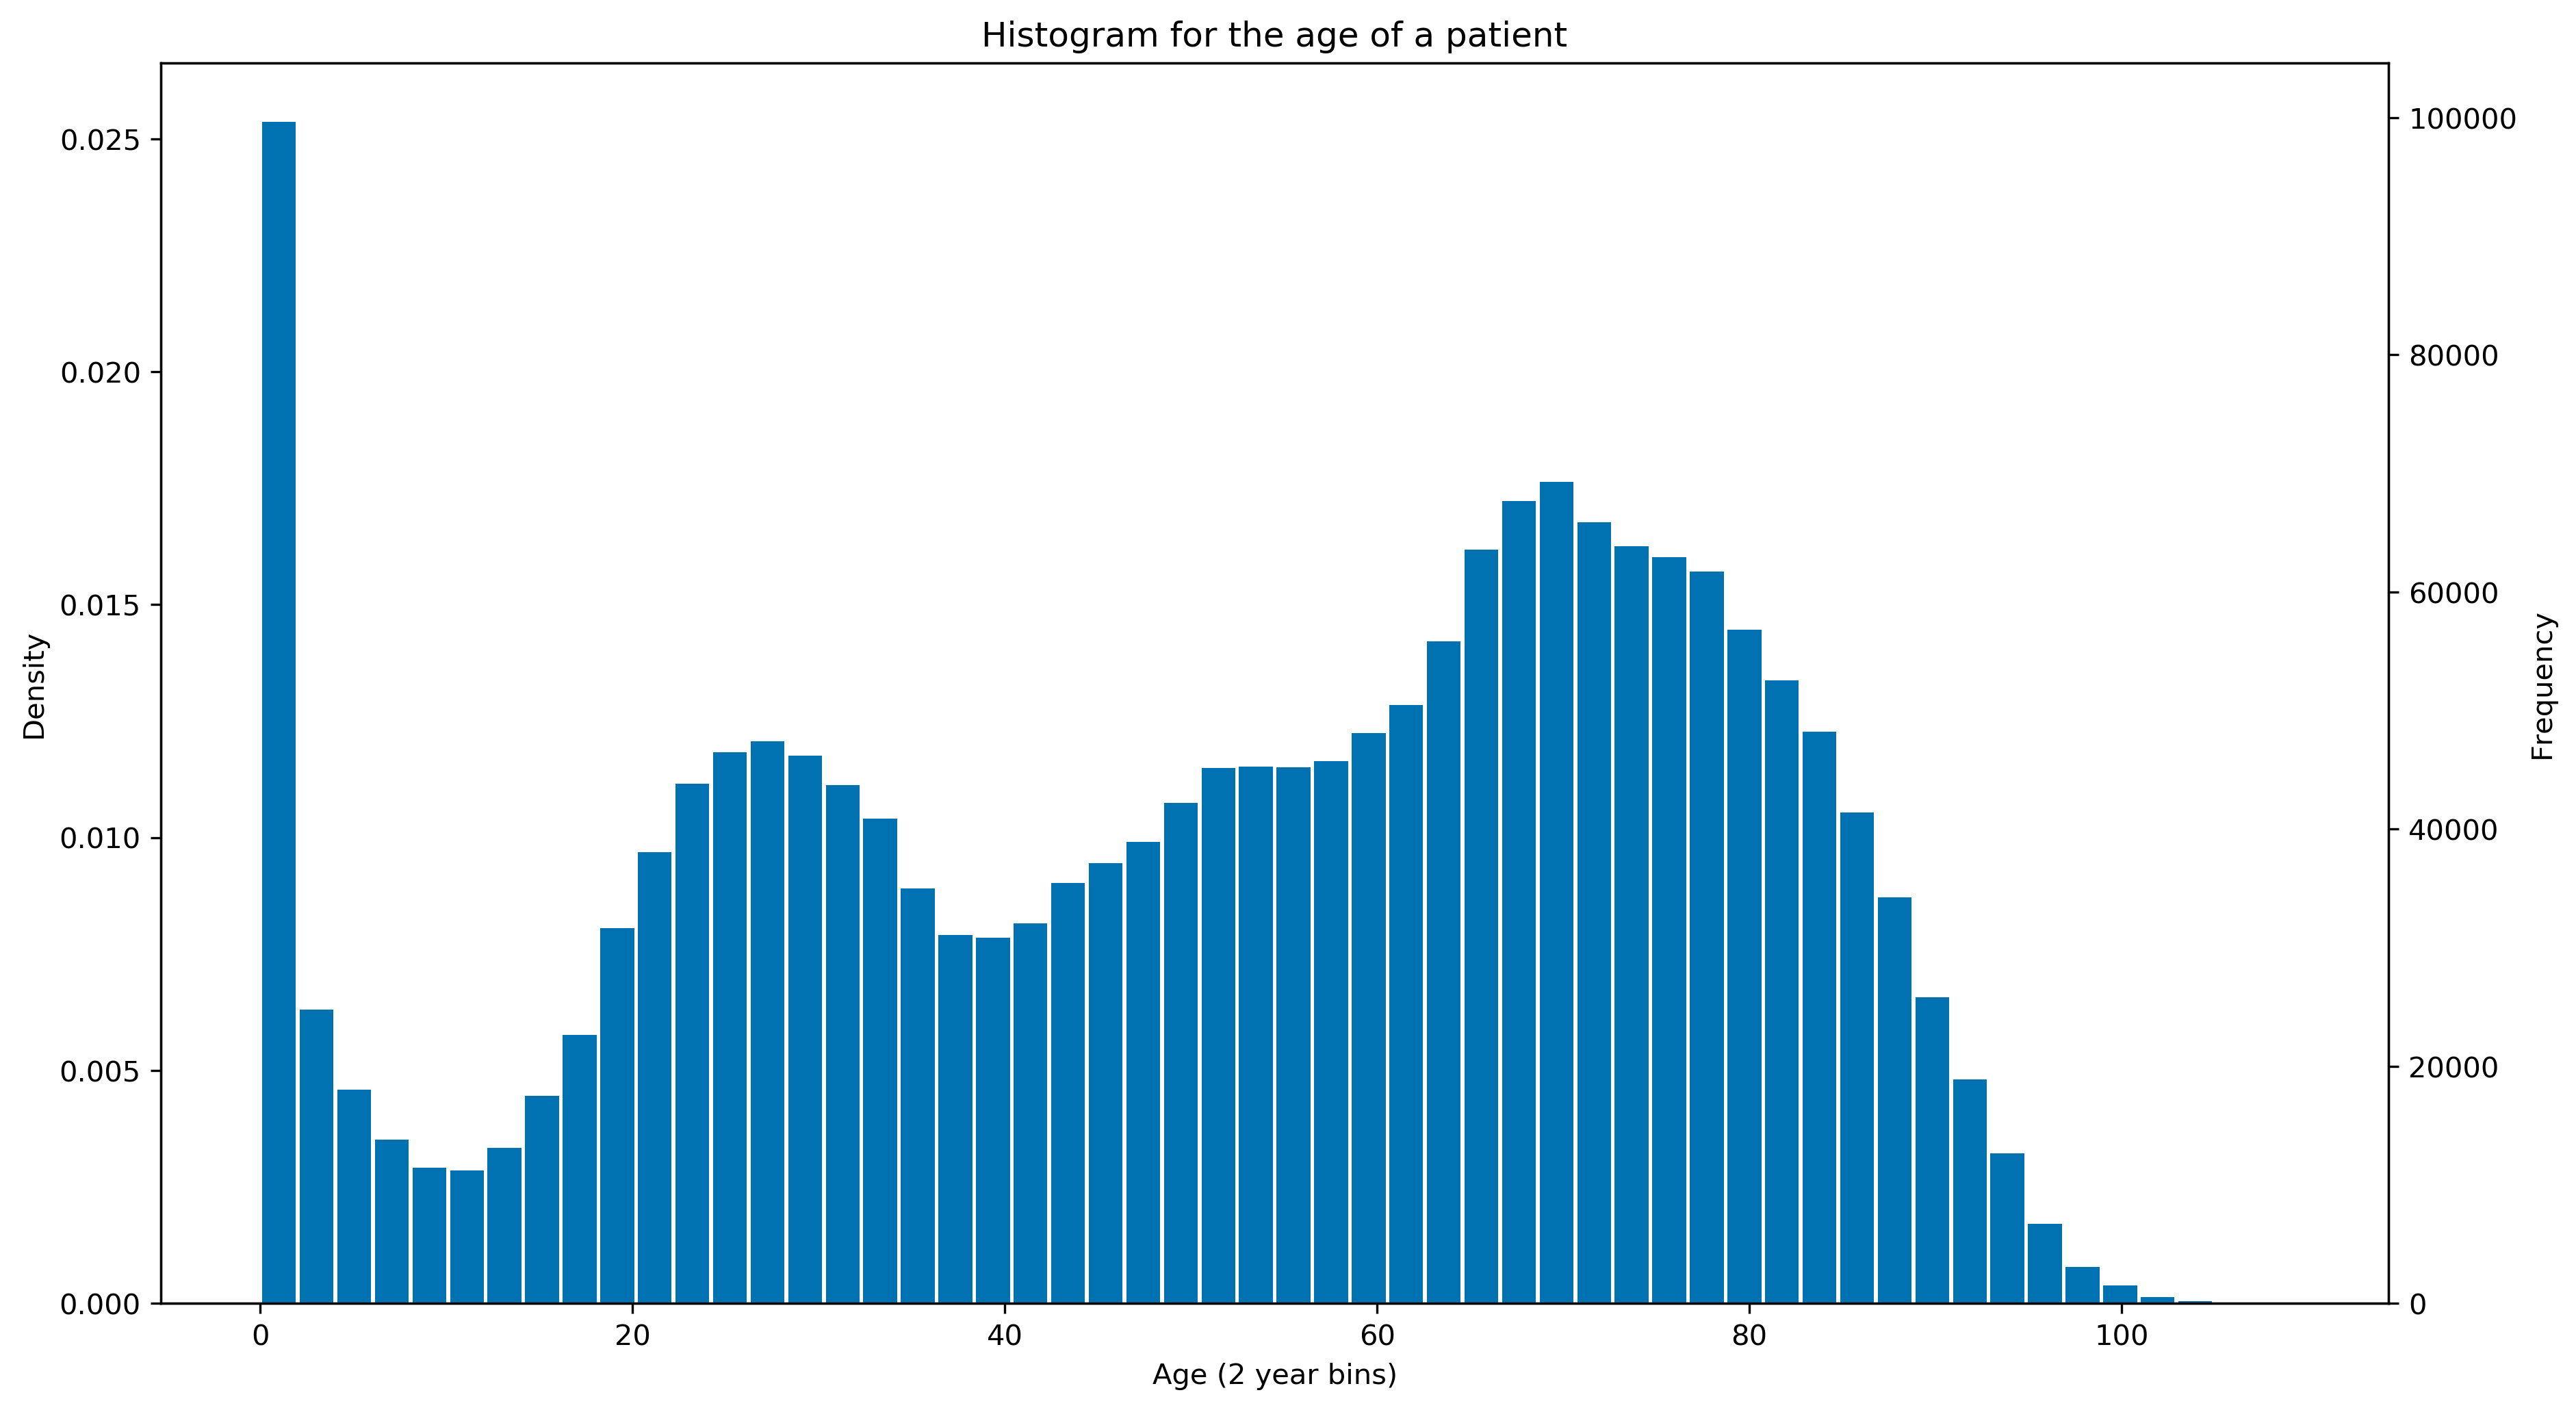

In [228]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

ax.hist(ages, int(ages.max() / 2), rwidth=0.9, density=True)
ax2 = ax.twinx()
ax2.hist(ages, int(ages.max() / 2), rwidth=0.9)

# minor_locs = MultipleLocator(10000)
# ax.minorticks_on()
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')

ax.set_xlabel('Age (2 year bins)')
ax.set_ylabel('Density')
ax2.set_ylabel('Frequency')
ax.set_title('Histogram for the age of a patient')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/age_hist.pdf');

In [229]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(ages, int(ages.max() / 2), rwidth=0.9)

# minor_locs = MultipleLocator(10000)
# ax.minorticks_on()
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')
# ax.set_ylabel('Frequency')
# ax.set_xlabel('Age (2 year bins)')
# ax.set_title('Histogram for the age of a patient')

# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/age_freq_hist.pdf');

In [230]:
# fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

# ax.hist(ages, int(ages.max() / 2), rwidth=0.9, density=True)

# minor_locs = MultipleLocator(0.0025)
# ax.minorticks_on()
# ax.yaxis.set_minor_locator(minor_locs)
# ax.set_axisbelow(True)
# ax.grid(b=True, which='minor', axis='y')
# ax.set_ylabel('Frequency density')
# ax.set_xlabel('Age (2 year bins)')
# ax.set_title('Density histogram for the age of a patient')

# plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/age_density_hist.pdf');

### Are there any other meaningful demographics to examine?

- Gender
    - This is not something that is well-recorded in the data, and largely unimportant I suspect.
    - Why would one (of the two present in the data) gender cost more/less than the other really?


- Socio-economic status (this will require some assumptions about the practice they are registered to)
    - An interesting idea perhaps about impoverished and affluent areas. See Geraint's [blog post](http://www.geraintianpalmer.org.uk/2017/09/22/plotting-geopandas/) on GeoPandas.
    - Decoding of GP practices is done in `geographical_analysis.ipynb`.

# Taking a slice of the data: diabetes analysis
---

This is a known area of interest to the health board.

The general methodology here is to take a slice of the data (diabetic patients in this case) and then look at some surface-level statistics and patterns in the data, comparing and contrasting as we go. Perhaps from there we can develop some metrics around the quantity of resources used or build some kind of regression model that can indicate where our cost variations derive.

We begin by defining a new column in the dataset which combines the diabetes primary/secondary diagnosis columns. From here we can analyse the proportion of admissions that are diabetic and average length of stays of diabetic patients. This is done over time using monthly and yearly resampling.

Note that we trim the dataset to only include episodes with admission dates from April 2012 onwards and discharge dates prior to May 2017; this is because not all of our data sources range over the same periods of time and makes for more meaningful figures.

In [53]:
diabetes_present = (df['DiabetesPrim'] == 1) | (df['DiabetesSec'] == 1)
df['Diabetes'] = np.where(diabetes_present, 1, 0)

In [54]:
df[df['Diabetes'] == 1].PATIENT_ID.nunique() / df.PATIENT_ID.nunique()

0.08722228834289901

## Clinical variables

In [55]:
diab_diagnosis_numbers = df[df['Diabetes'] == 1].set_index('EPISODE_ID').DIAG_NO
nondiab_diagnosis_numbers = df[df['Diabetes'] == 0].set_index('EPISODE_ID').DIAG_NO

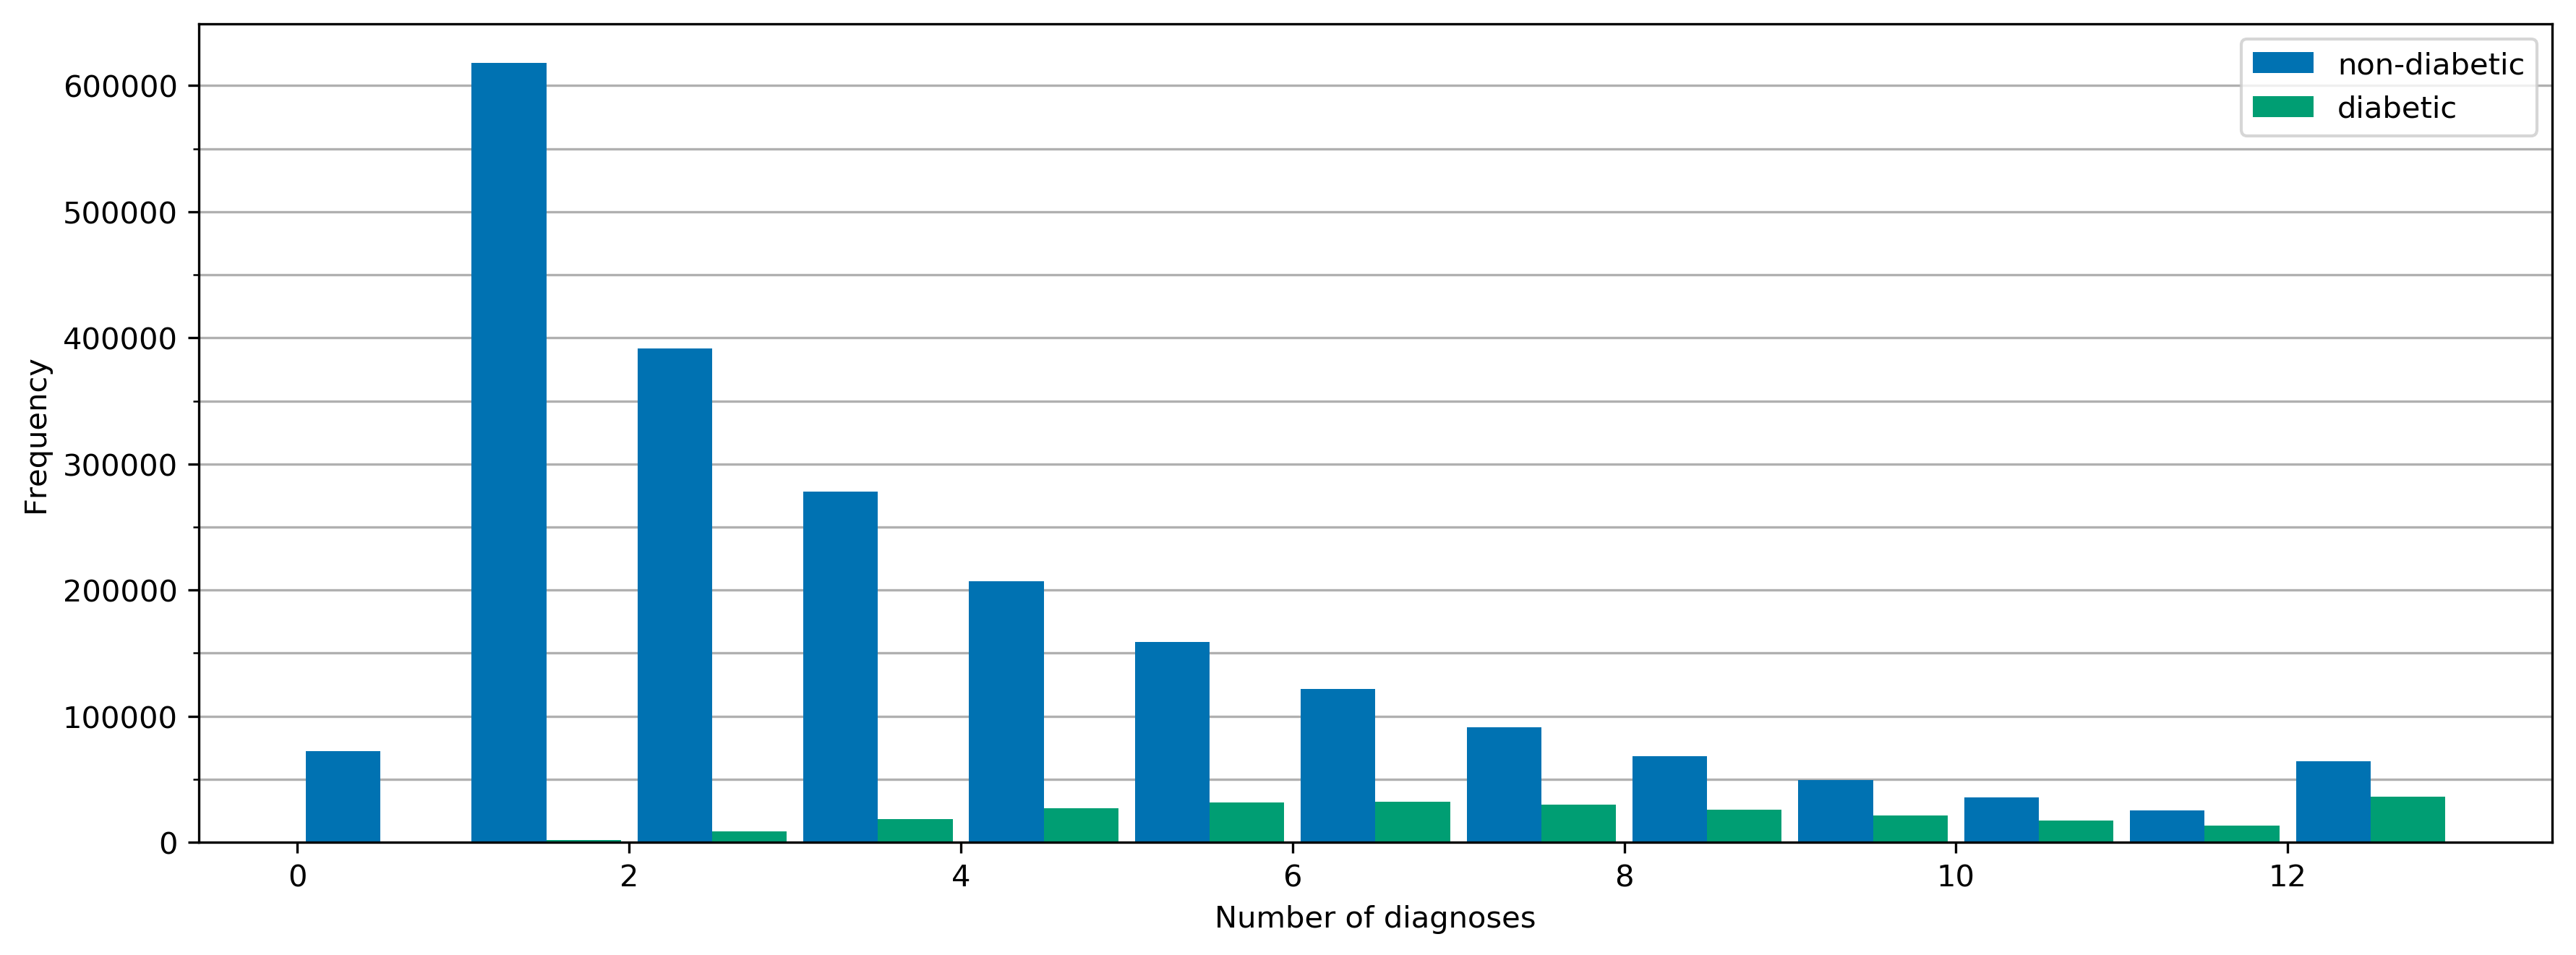

In [231]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_diagnosis_numbers.values, diab_diagnosis_numbers.values],
        nondiab_diagnosis_numbers.max(), rwidth=0.9)

ax.set_ylabel('Frequency')
ax.set_xlabel('Number of diagnoses')

minor_locs = MultipleLocator(50000)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')
ax.legend(['non-diabetic', 'diabetic'], loc='best')

# ax.set_title('Histogram for the number of diagnoses in an episode in the presence and absence of diabetes')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_diag_no_freq_hist.pdf');

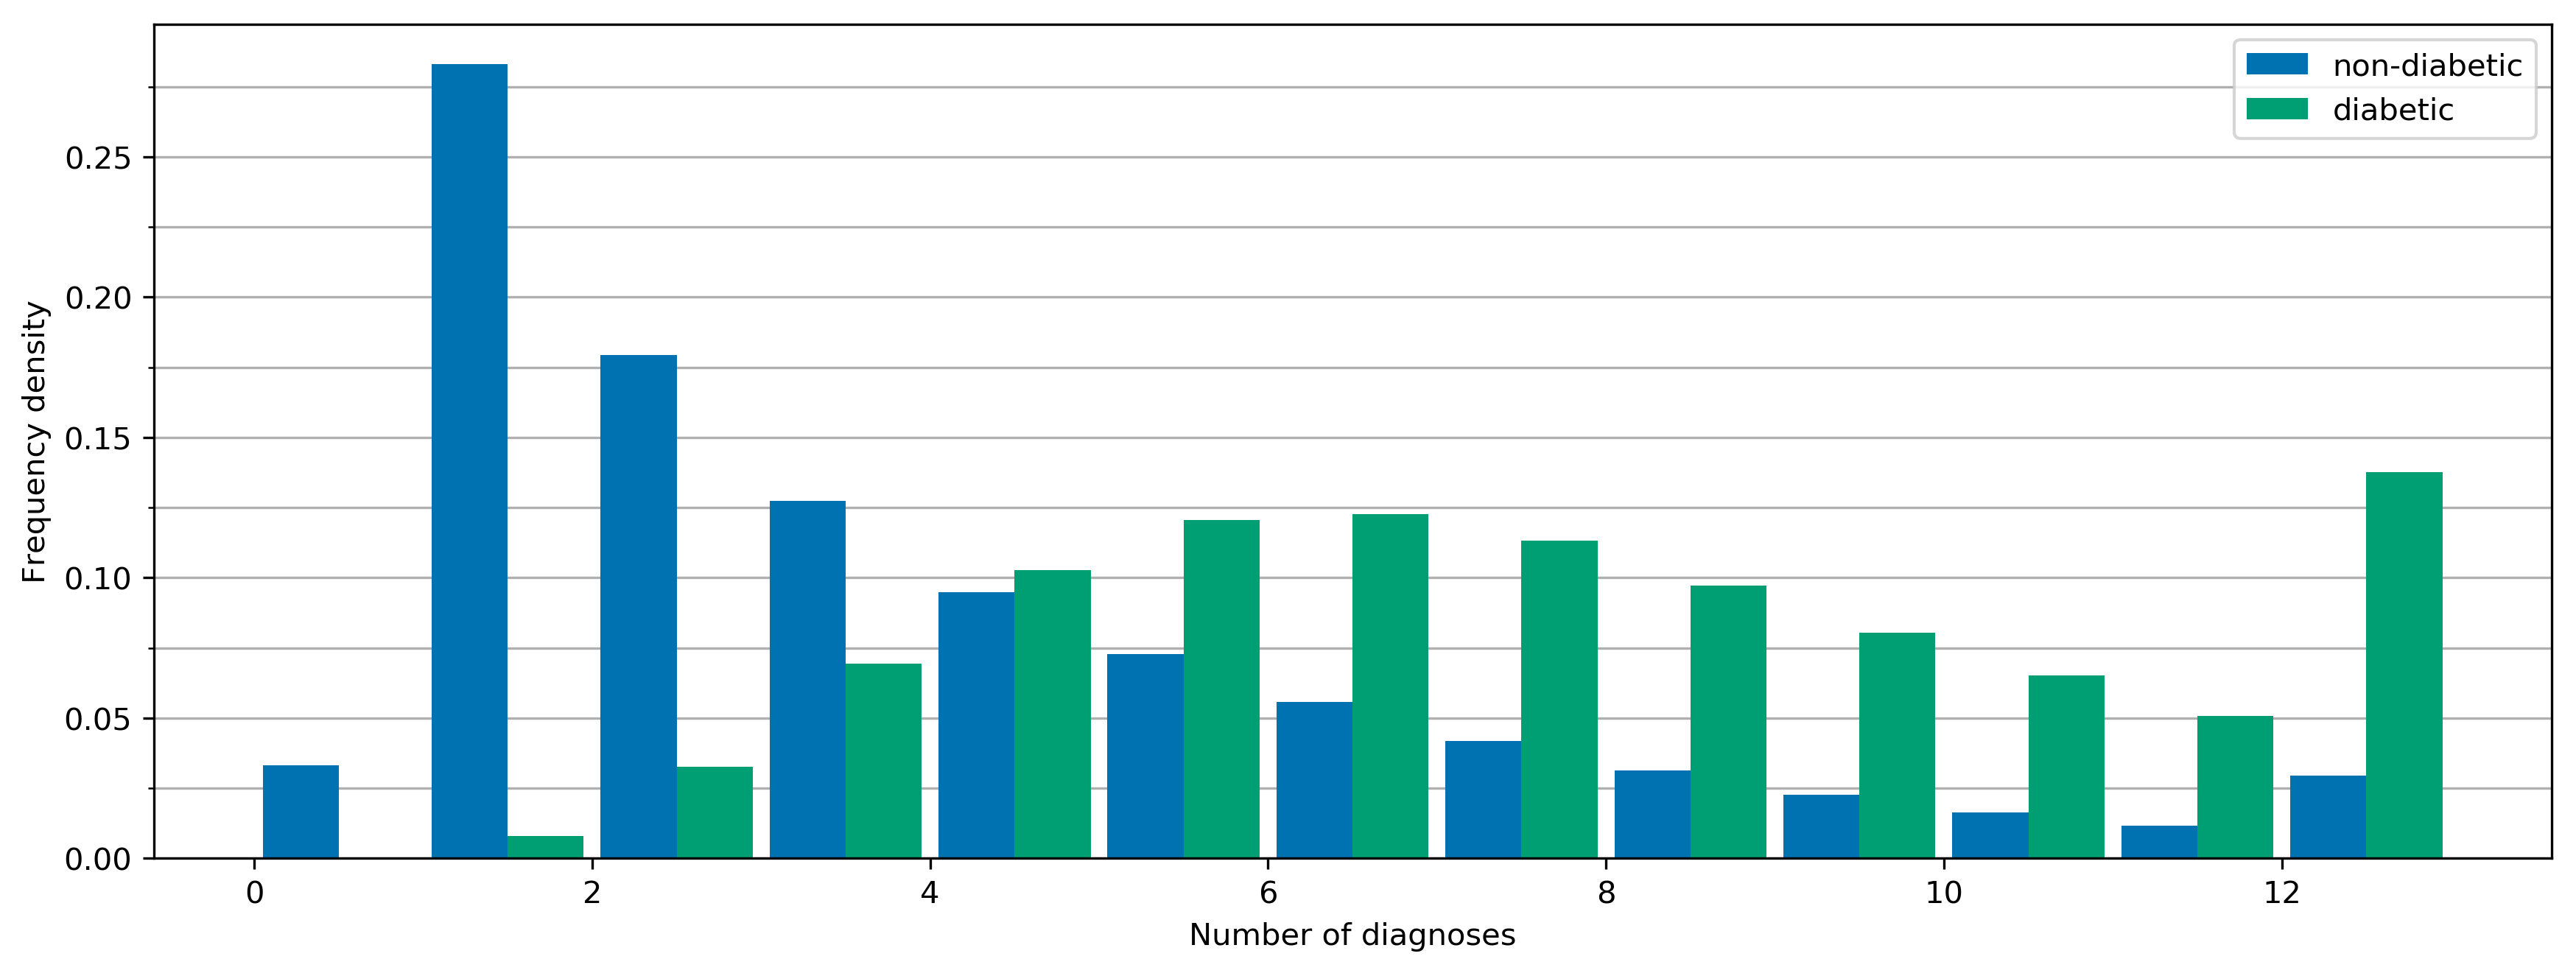

In [232]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_diagnosis_numbers.values, diab_diagnosis_numbers.values],
        nondiab_diagnosis_numbers.max(), rwidth=0.9, density=True)

ax.set_ylabel('Frequency density')
ax.set_xlabel('Number of diagnoses')

minor_locs = MultipleLocator(0.025)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')
ax.legend(['non-diabetic', 'diabetic'], loc='best')

# ax.set_title('Density histogram for the number of diagnoses in an episode in the presence and absence of diabetes')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_diag_no_density_hist.pdf');

In [65]:
diab_procedure_numbers = df[df['Diabetes'] == 1].set_index('EPISODE_ID').PROC_NO
nondiab_procedure_numbers = df[df['Diabetes'] == 0].set_index('EPISODE_ID').PROC_NO

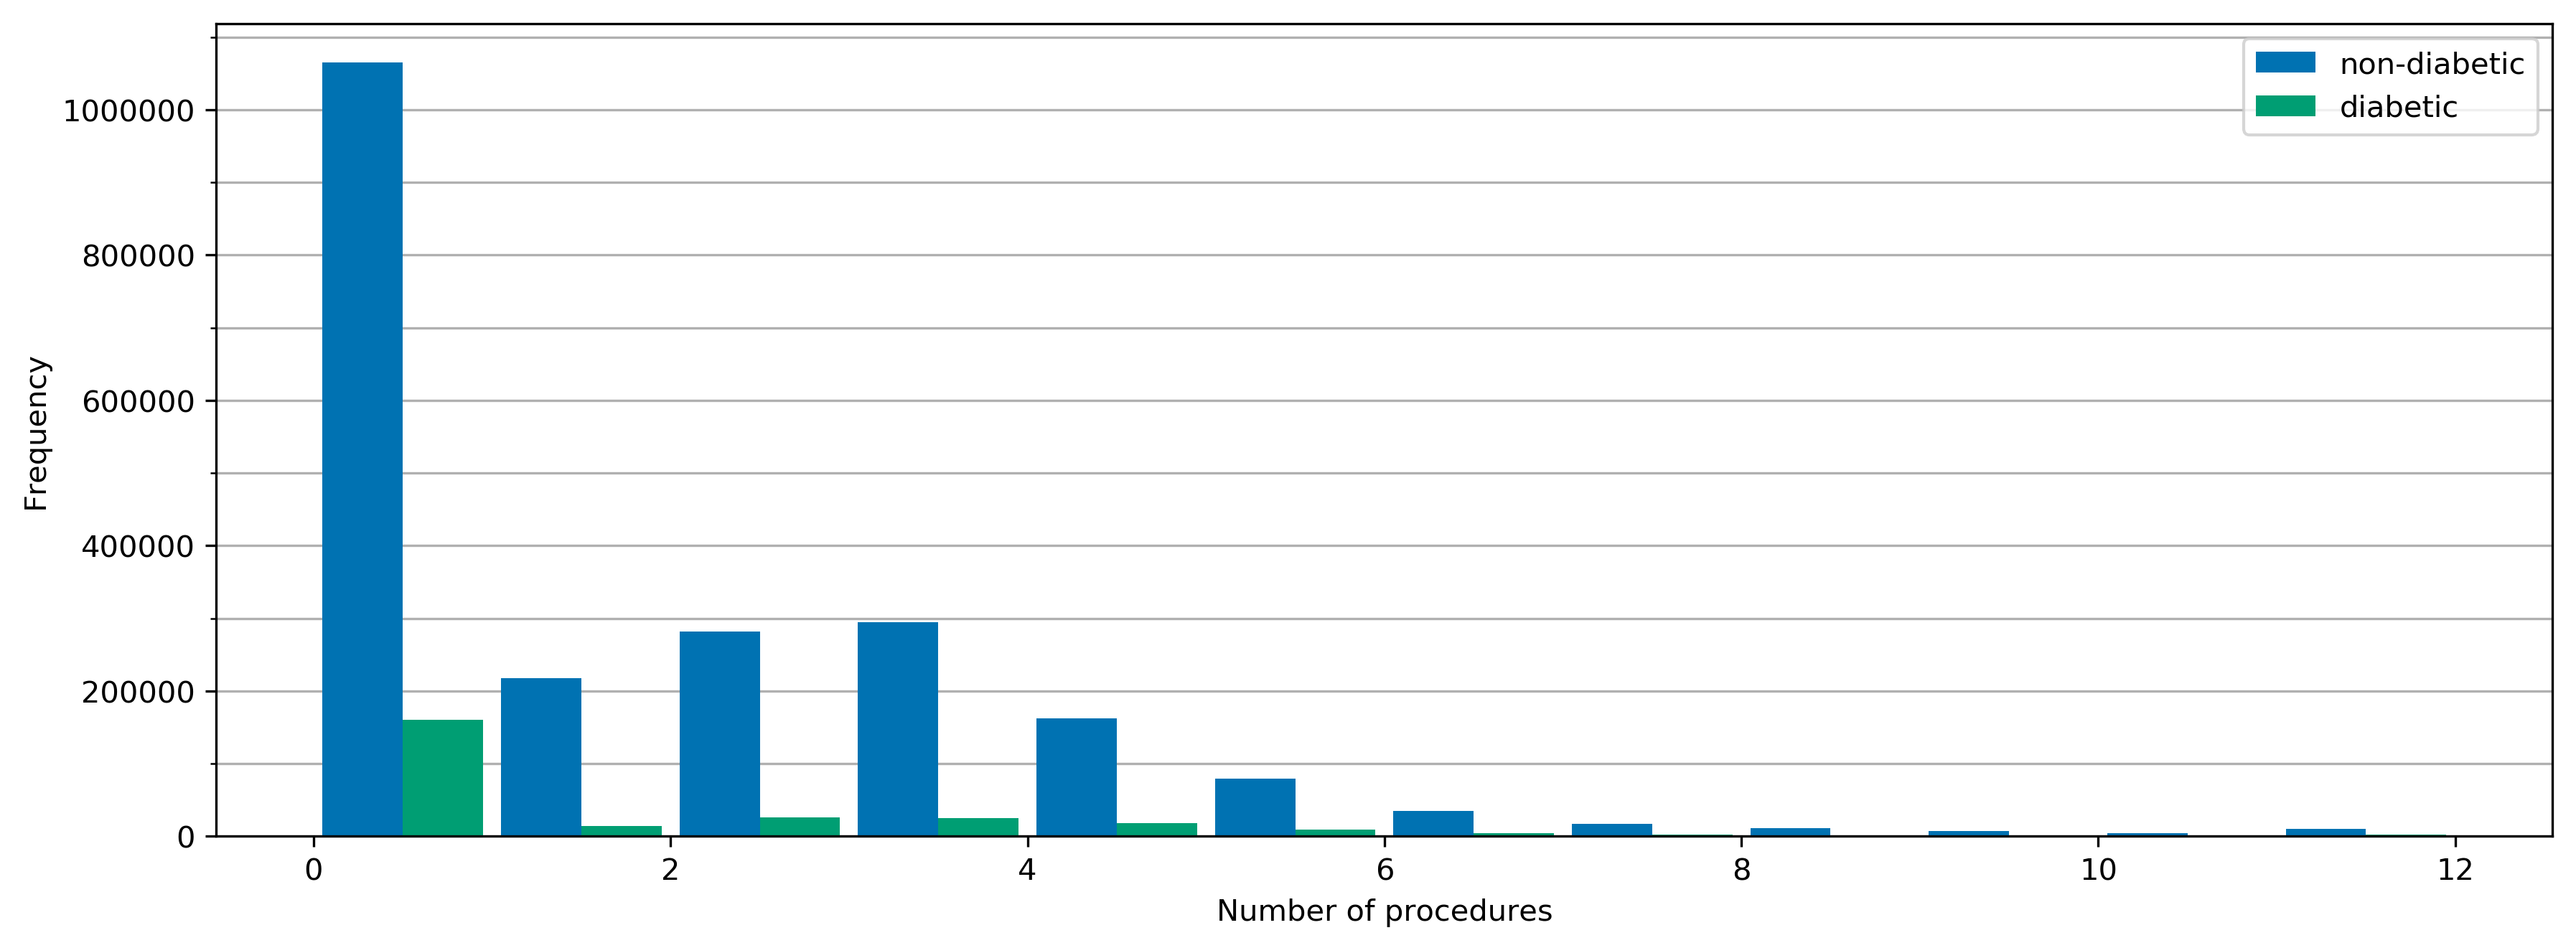

In [233]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_procedure_numbers.values, diab_procedure_numbers.values],
        nondiab_procedure_numbers.max(), rwidth=0.9)

ax.set_ylabel('Frequency')
ax.set_xlabel('Number of procedures')

minor_locs = MultipleLocator(100000)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')
ax.legend(['non-diabetic', 'diabetic'], loc='best')

# ax.set_title('Histogram for the number of procedures in an episode in the presence and absence of diabetes')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_proc_no_freq_hist.pdf');

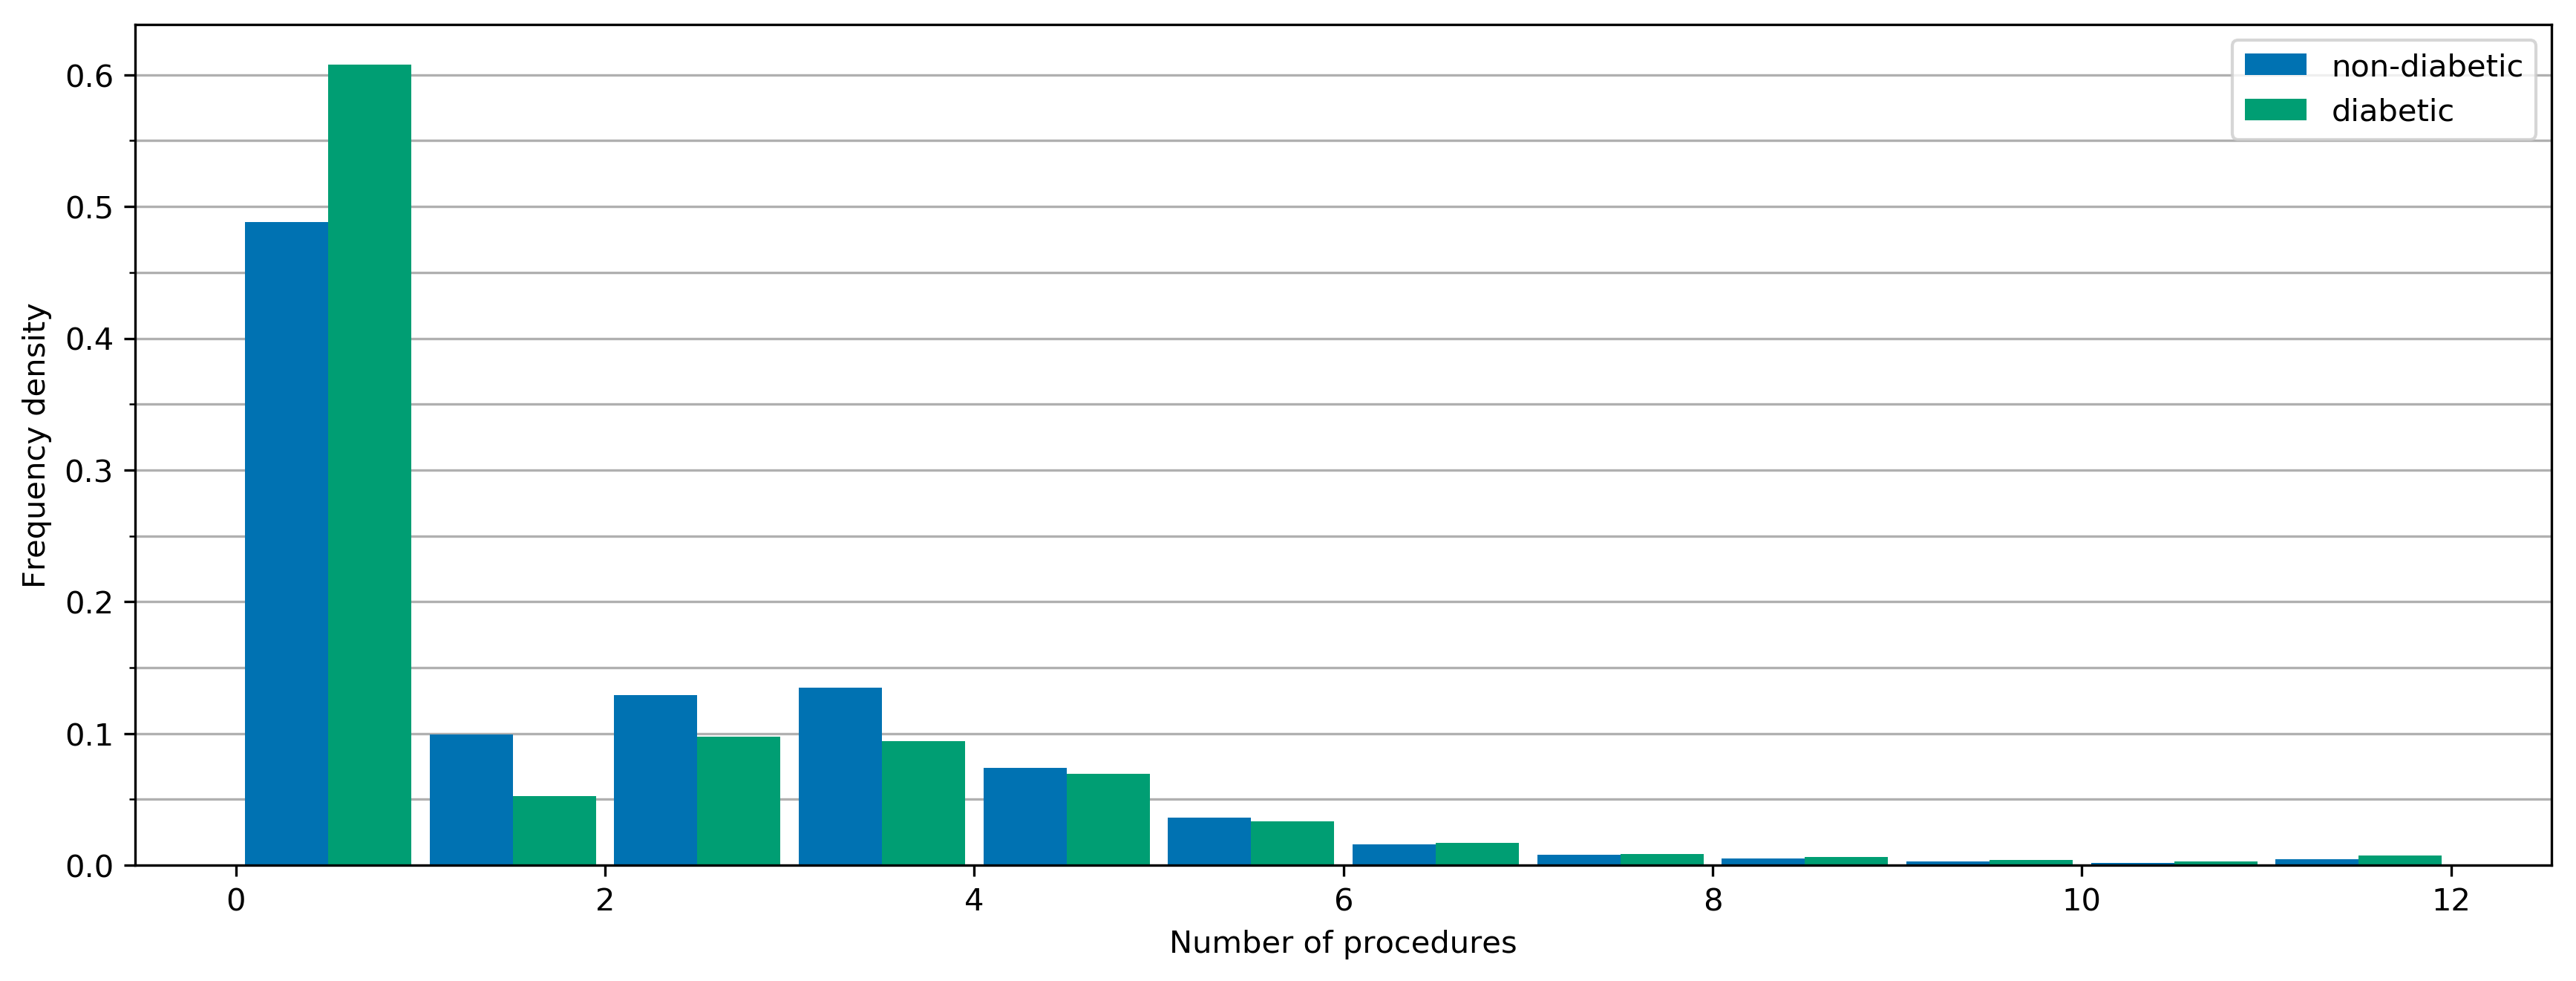

In [234]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_procedure_numbers.values, diab_procedure_numbers.values],
        nondiab_procedure_numbers.max(), rwidth=0.9, density=True)

ax.set_ylabel('Frequency density')
ax.set_xlabel('Number of procedures')

minor_locs = MultipleLocator(0.05)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')
ax.legend(['non-diabetic', 'diabetic'], loc='best')

# ax.set_title('Density histogram for the number of procedures in an episode in the presence and absence of diabetes')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_proc_no_density_hist.pdf');

## Diabetic demographics

In [ ]:
diab_ages = df[df['Diabetes'] == 1].set_index('PATIENT_ID').drop_duplicates('SPELL_ID').Age.dropna().values

In [ ]:
nondiab_ages = df[df['Diabetes'] == 0].set_index('PATIENT_ID').drop_duplicates('SPELL_ID').Age.dropna().values

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_ages, diab_ages], int(ages.max() / 2))

minor_locs = MultipleLocator(10000)
ax.minorticks_on()
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')
ax.legend(['non-diabetic', 'diabetic'], loc='best')
ax.set_xlabel('Age (2 year bins)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of patient age in the presence and absence of diabetes')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_age_freq_hist.pdf');

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_ages, diab_ages], int(ages.max() / 2), density=True)

minor_locs = MultipleLocator(0.0025)
ax.minorticks_on()
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')
ax.legend(['non-diabetic', 'diabetic'], loc='best')
ax.set_xlabel('Age (2 year bins)')
ax.set_ylabel('Estimated probability density')
ax.set_title('Density histogram of patient age in the presence and absence of diabetes')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_age_density_hist.pdf');

## Correlations

In [75]:
diab_sum_costs = df[df['Diabetes'] == 1].groupby('SPELL_ID')[costs].sum()
diab_true_lengths = df[df['Diabetes'] == 1].groupby('SPELL_ID').TRUE_LOS.mean()
diab_diag_proc = df[df['Diabetes'] == 1].groupby('SPELL_ID')[['DIAG_NO', 'PROC_NO']].max()

diab_data = pd.concat([diab_sum_costs, diab_true_lengths, diab_diag_proc], axis=1)

In [76]:
diab_correlation = diab_data.corr().round(2)

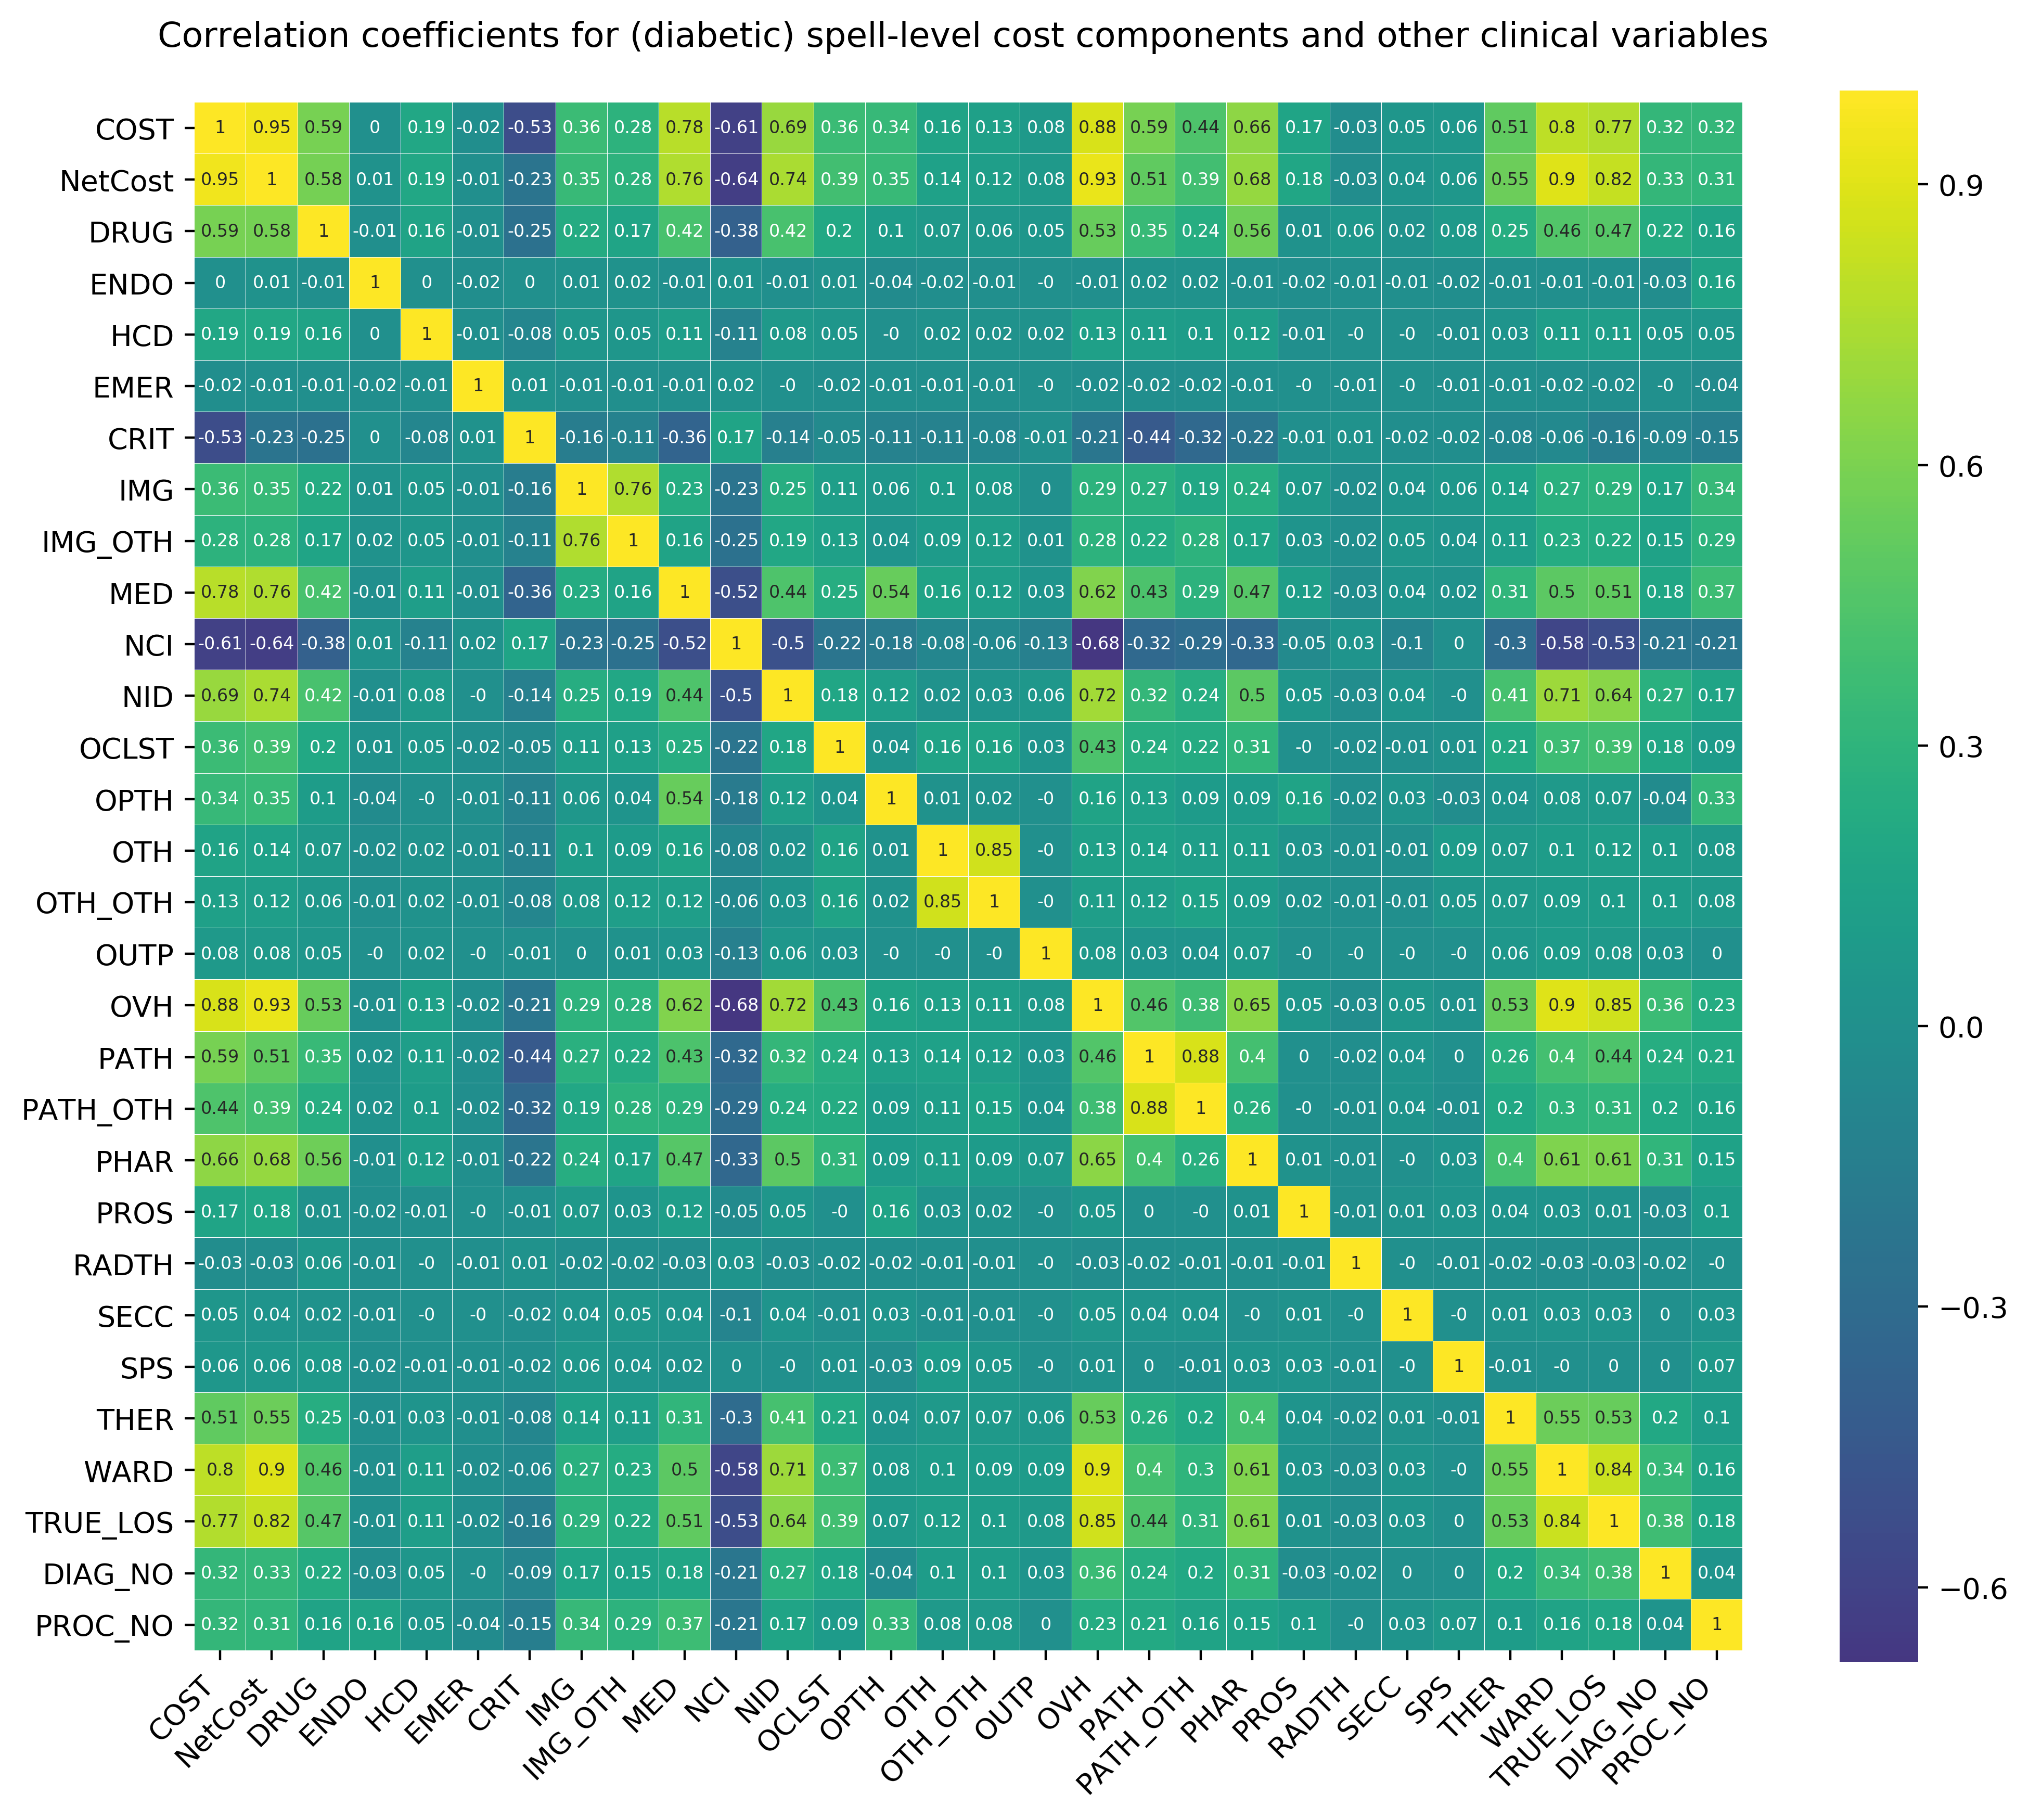

In [77]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=400)

sbn.heatmap(diab_correlation, square=True, cmap='viridis', center=0,
            linewidths=0.01, annot=True, annot_kws={'fontsize': 6}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

ax.set_title('Correlation coefficients for (diabetic) spell-level cost components and other clinical variables \n')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_corr_heatmap.pdf', transparent=True);

In [78]:
differences = diab_correlation - correlation

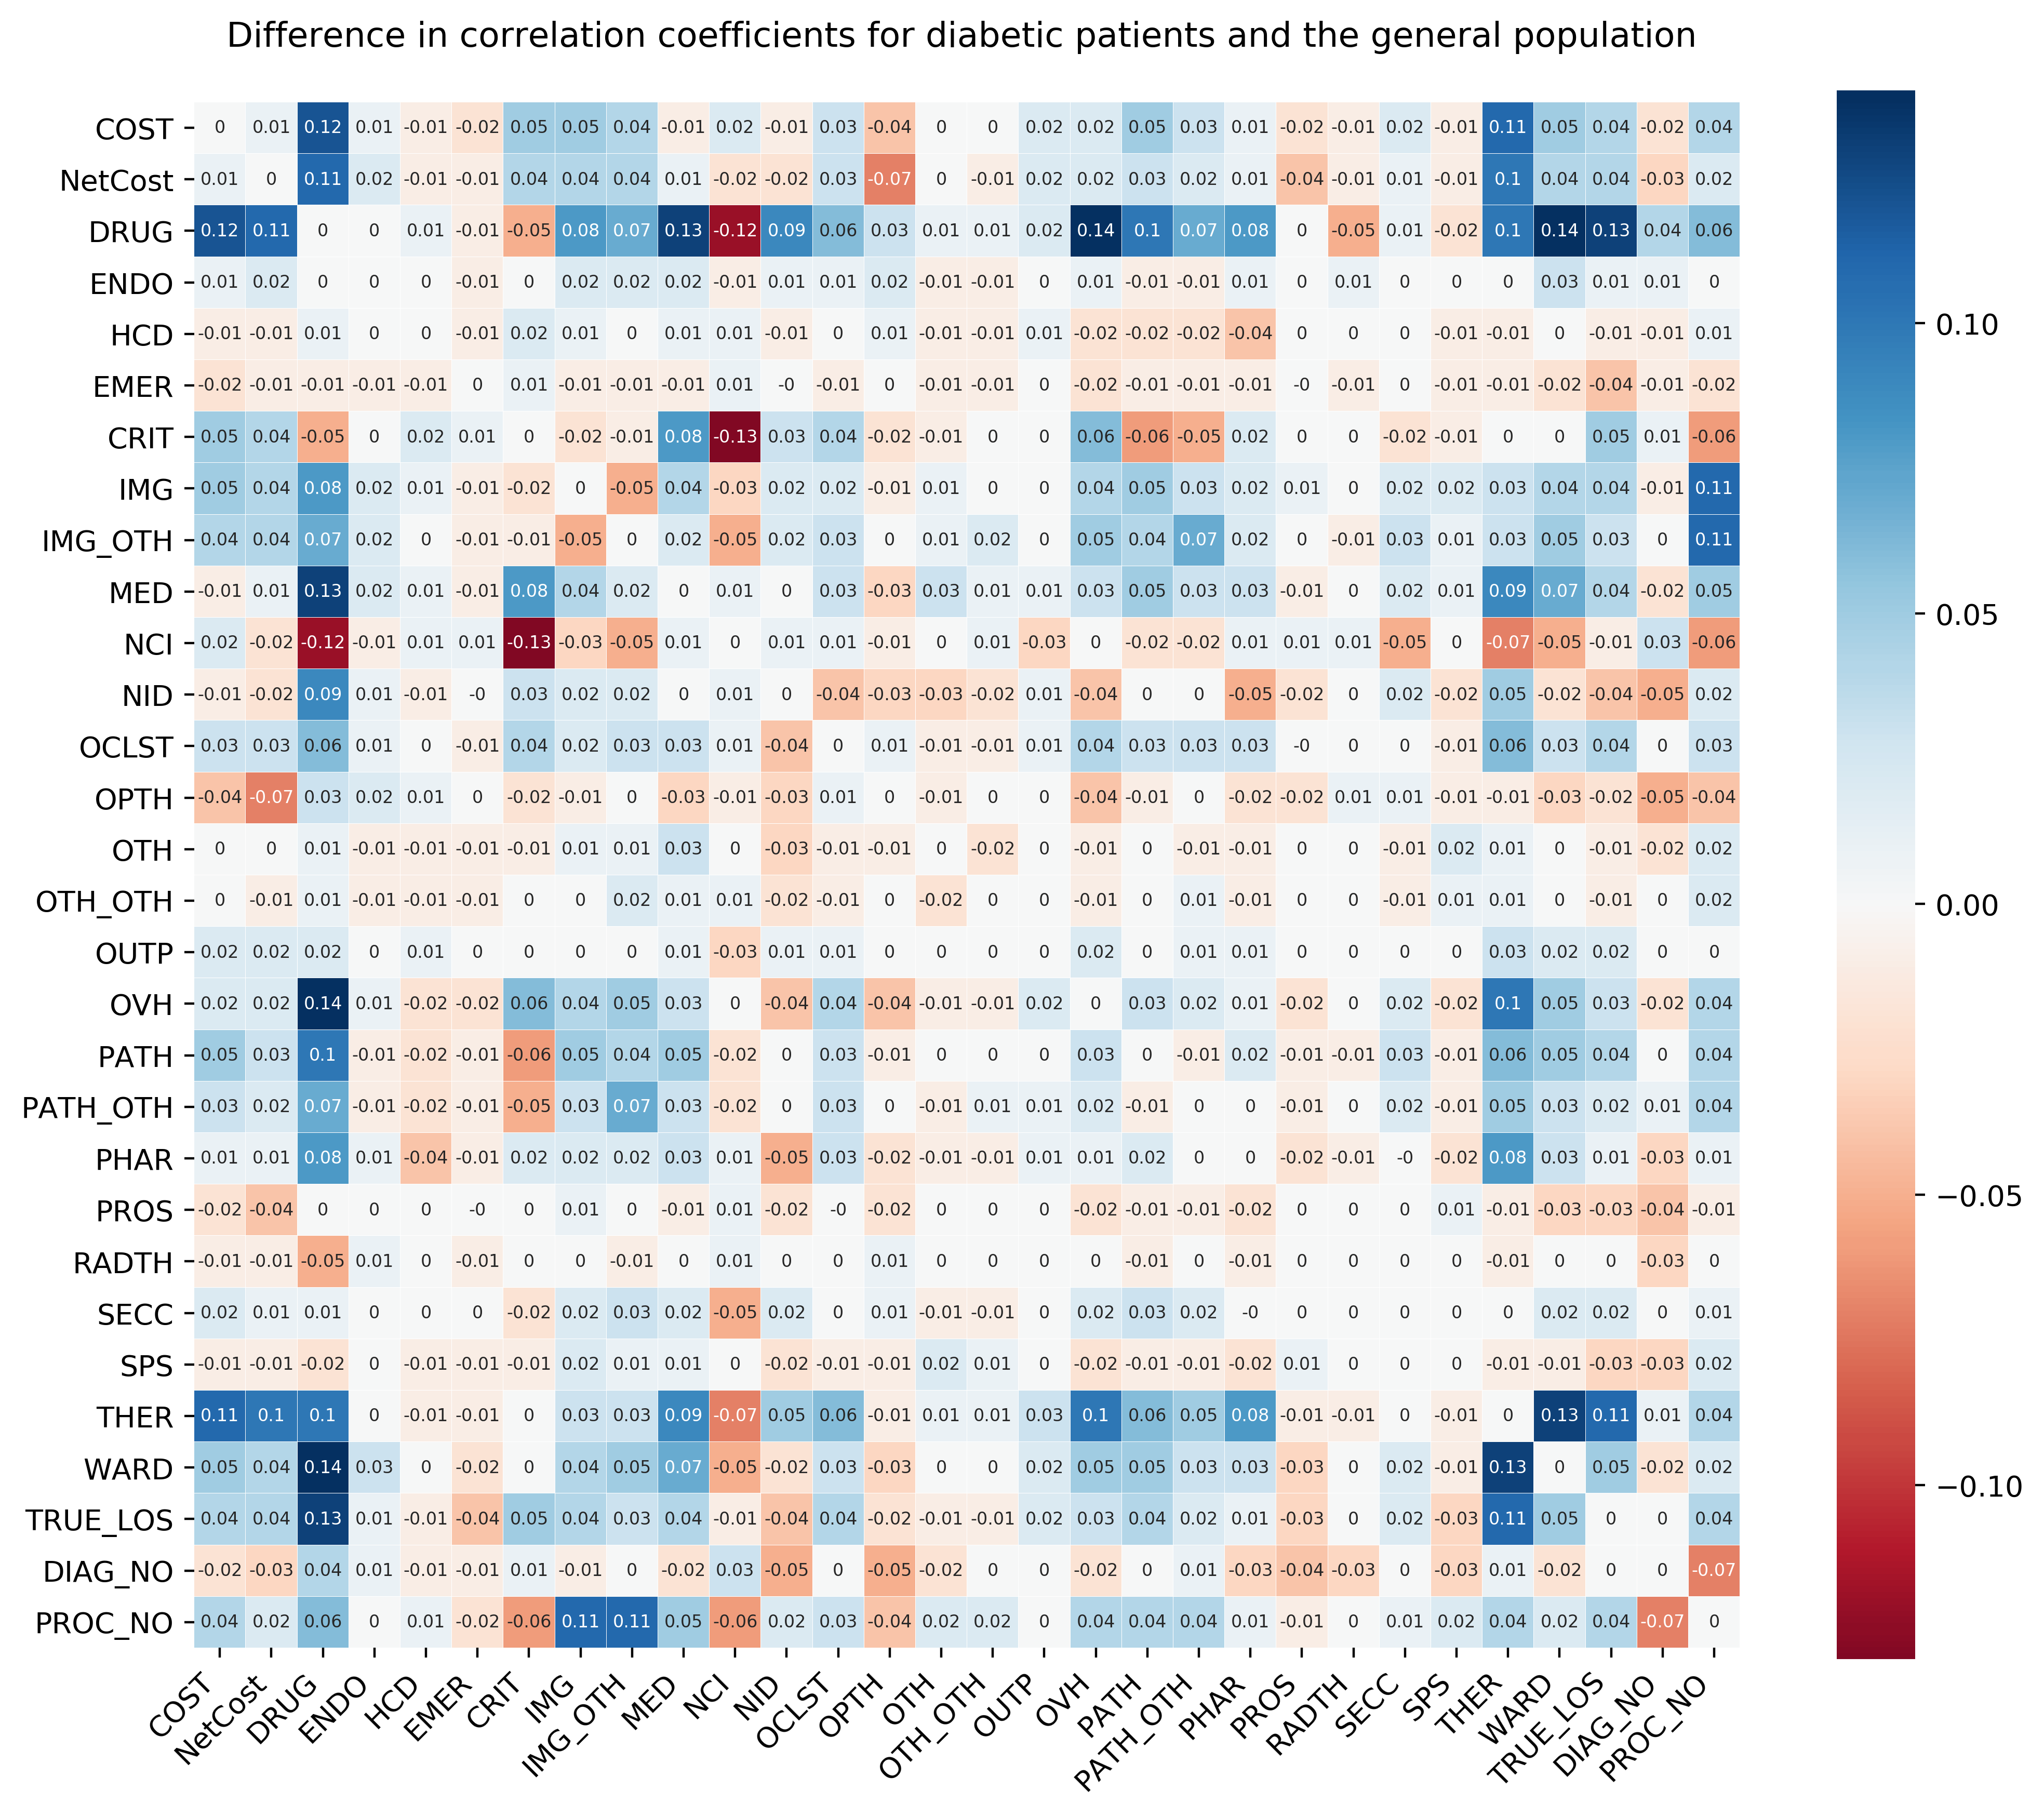

In [115]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=400)

sbn.heatmap(differences, square=True, cmap='RdBu', center=0,
            linewidths=0.01, annot=True, annot_kws={'fontsize': 6}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

ax.set_title('Difference in correlation coefficients for diabetic patients and the general population \n')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/differences_corr_heatmap.pdf', transparent=True);

In [117]:
ratio = diab_correlation.divide(correlation, axis=0).replace([np.infty, -np.infty], np.nan)

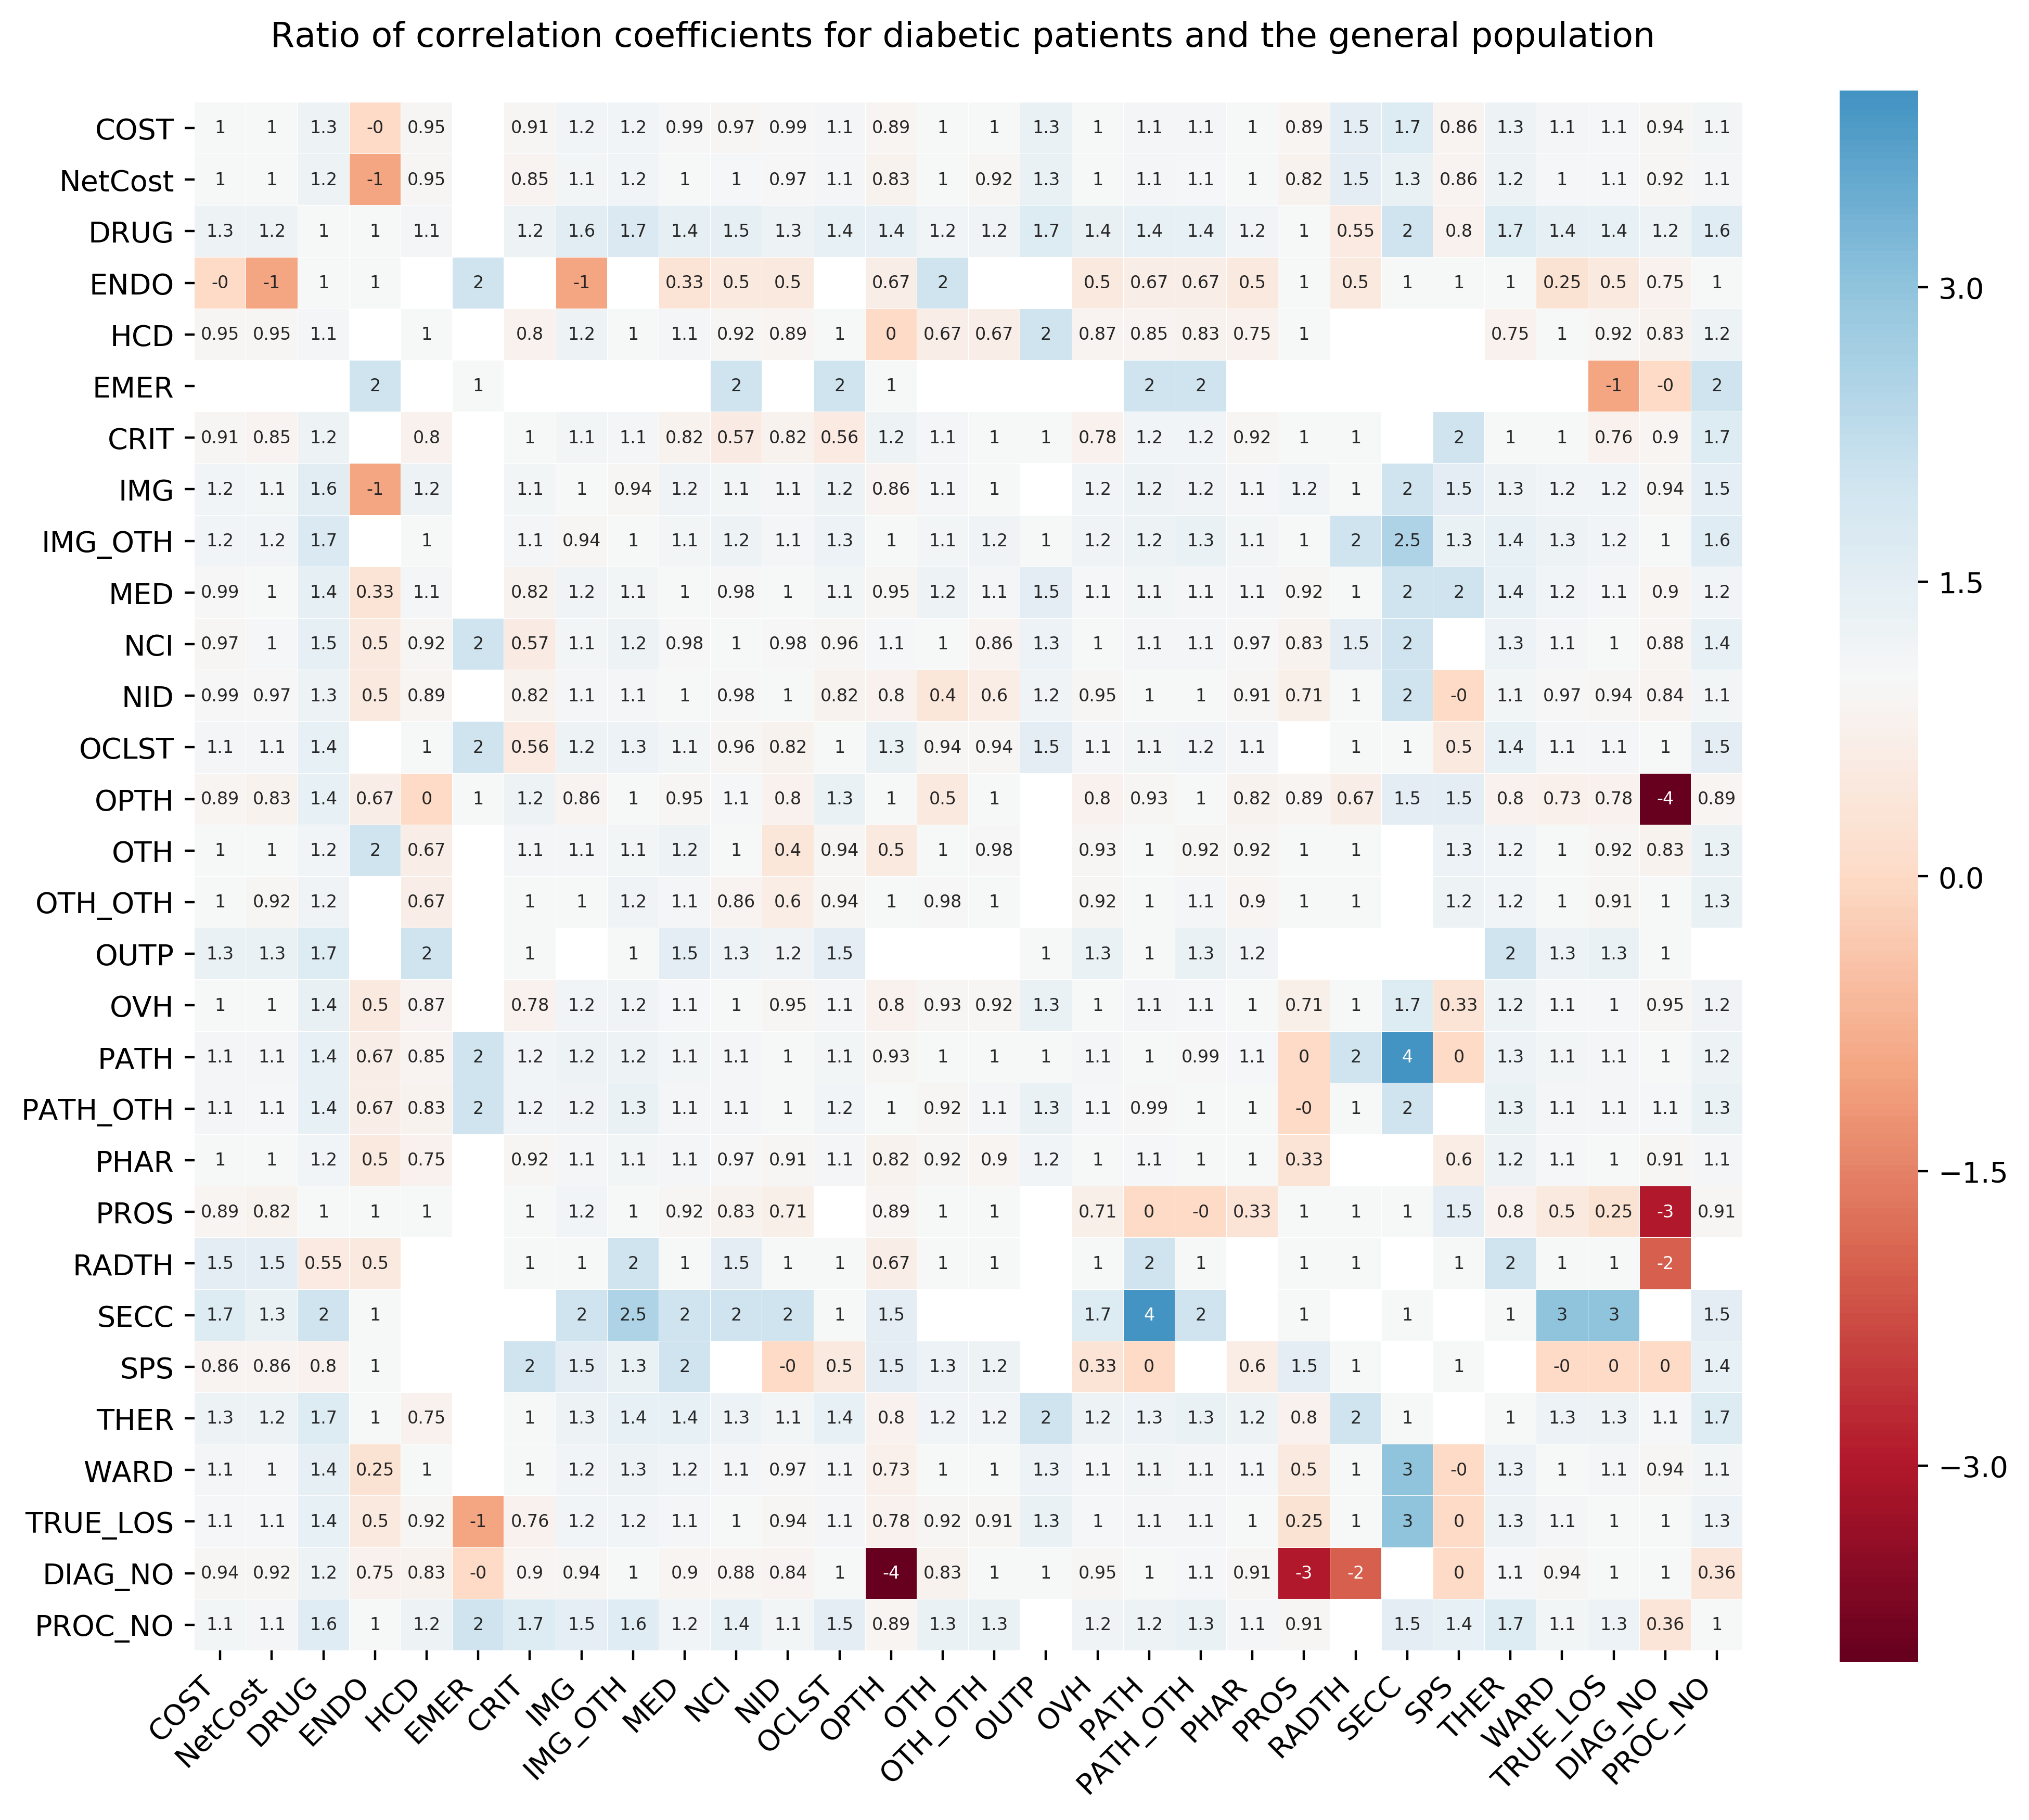

In [118]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=400)

sbn.heatmap(ratio, square=True, cmap='RdBu', center=1,
            linewidths=0.01, annot=True, annot_kws={'fontsize': 6}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

ax.set_title('Ratio of correlation coefficients for diabetic patients and the general population \n')
plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/ratio_corr_heatmap.pdf', transparent=True);

## Number of spells

In [ ]:
diab_nspells = df[df['Diabetes'] == 1].groupby('PATIENT_ID').SPELL_ID.nunique().values
nondiab_nspells = df[df['Diabetes'] == 0].groupby('PATIENT_ID').SPELL_ID.nunique().values

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_nspells, diab_nspells], nspells.max(), rwidth=0.9)

minor_locs = MultipleLocator(50000)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')
ax.set_xlim(0.8, 15)
ax.set_xticks(np.arange(1, 15))
ax.set_xlabel('Number of spells')
ax.set_ylabel('Frequency density')
ax.legend(['non-diabetic', 'diabetic'], loc='best')
ax.set_title('Histogram for the total number of spells associated with a patient')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_no_spells_freq_hist.pdf');

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_nspells, diab_nspells], nspells.max(), rwidth=0.9, density=True)

minor_locs = MultipleLocator(0.05)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')
ax.set_xlim(0.8, 15)
ax.set_xticks(np.arange(1, 15))
ax.set_xlabel('Number of spells')
ax.set_ylabel('Frequency density')
ax.legend(['non-diabetic', 'diabetic'], loc='best')
ax.set_title('Density histogram for the total number of spells associated with a patient')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_no_spells_density_hist.pdf');

## Diabetic admissions as a proportion of the total daily admissions

It seems intuitive to the consider what proportion of admissions our slice make up; this acts as an indicator of how resources or system costs are distributed to the subset we're interested in.

Let's calculate the number of admissions for the whole dataset and for diabetic patients each day. We do this by grouping our dataset by admission date and counting the number of unique spells for each admission date.

- Reworking the length of stay, finding the proportion of 'resources' (cost, beds, etc) that are diabetic

In [ ]:
num_admissions = df[time_constraint].groupby('ADMDATE').SPELL_ID.nunique().reset_index() \
                                                       .rename({'SPELL_ID': 'nunique_spells'}, axis=1) \
                                                       .groupby('ADMDATE').nunique_spells.sum()

In [ ]:
diab_admissions = df[(df['Diabetes'] == 1) & (time_constraint)].groupby('ADMDATE').SPELL_ID.nunique().reset_index() \
                                                               .rename({'SPELL_ID': 'nunique_spells'}, axis=1) \
                                                               .groupby('ADMDATE').nunique_spells.sum()

diabprim_admissions = df[(df['DiabetesPrim'] == 1) & (time_constraint)].groupby('ADMDATE').SPELL_ID.nunique().reset_index() \
                                                                       .rename({'SPELL_ID': 'nunique_spells'}, axis=1) \
                                                                       .groupby('ADMDATE').nunique_spells.sum()

diabsec_admissions = df[(df['DiabetesSec'] == 1) & (time_constraint)].groupby('ADMDATE').SPELL_ID.nunique().reset_index() \
                                                                     .rename({'SPELL_ID': 'nunique_spells'}, axis=1) \
                                                                     .groupby('ADMDATE').nunique_spells.sum()

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

diab_props = diab_admissions / num_admissions
diab_props.dropna(inplace=True)

monthly = diab_props.resample('BM').mean()
yearly = monthly.resample('BA-APR').mean()
yearly_err = monthly.resample('BA-APR').std().bfill()

errorbar_params = pd.DataFrame(yearly_err).rename({'nunique_spells': 'err'}, axis=1)
errorbar_params['val'] = yearly.values
errorbar_params['vmin'] = errorbar_params['val'] - errorbar_params['err']
errorbar_params['vmax'] = errorbar_params['val'] + errorbar_params['err']

X, y = date2num(diab_props.index.values.reshape(-1,1)), diab_props.values.reshape(-1,1)
lr = LinearRegression()
lr.fit(X, y)
linreg_df = pd.DataFrame(lr.predict(X), index=diab_props.index)

ax.errorbar(errorbar_params.index, errorbar_params['val'], errorbar_params['err'],
            capsize=8, alpha=0.25, ecolor='k', linestyle='', label='Standard dev.')
ax.plot(monthly, '.', alpha=0.75, label='End of month avg.')
ax.plot(yearly, 'x', label='End of year avg.')
ax.plot(linreg_df, '-', label='Lin. regression model')

ax.set_title('Diabetic admissions as a proportion of total admissions')
ax.set_xlabel('Admission date')
ax.set_ylabel('Proportion of total admissions')
ax.legend(loc='best')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_admissions.pdf');

In [ ]:
diabprim_props = diabprim_admissions / num_admissions
diabprim_props.dropna(inplace=True)
diabsec_props = diabsec_admissions / num_admissions
diabsec_props.dropna(inplace=True)

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

primary = diabprim_props.resample('BA-APR').mean().values
secondary = diabsec_props.resample('BA-APR').mean().values
combined = yearly.values

width = 0.4
inds = np.arange(len(primary))

ax.bar(inds, secondary, width, label='secondary')
ax.bar(inds+width, primary, width, label='primary')

ax.set_xticks(inds + width/2)
ax.set_xticklabels(['2012', '2013', '2014', '2015', '2016', '2017'])
ax.set_ylabel('Proportion of admissions')
ax.set_title('Proportion of average yearly diabetic admissions as a primary or secondary condition')
ax.legend(loc='best')

yminor_locs = MultipleLocator(0.01)
ax.yaxis.set_minor_locator(yminor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_primsec_admissions.pdf');

## Diabetic cost component variation

In [ ]:
diab_costs = df[df['Diabetes'] == 1].groupby('SPELL_ID')[costs].sum()
nondiab_costs = df[df['Diabetes'] == 0].groupby('SPELL_ID')[costs].sum()

In [ ]:
diab_var = diab_costs.std() / diab_costs.mean()
nondiab_var = nondiab_costs.std() / nondiab_costs.mean()

variations = pd.concat([nondiab_var, diab_var], axis=1) \
               .rename({0: 'nondiab', 1: 'diab'}, axis=1) \
               .sort_values('nondiab', ascending=False)

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

width = 0.4
inds = np.arange(len(variations))

ax.bar(inds, variations['nondiab'].values, width, label='non-diabetic')
ax.bar(inds+width, variations['diab'].values, width, label='diabetic')

ax.set_title(r'Coefficient of variation ($C_v$) for each cost component')
ax.set_xticks(inds + width/2)
ax.set_xticklabels(variations.index)
ax.set_ylabel(r'$C_v$')
ax.legend(loc='best')

minor_locs = MultipleLocator(5)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_coeff_variation.pdf');

## Cost component contribution

In [ ]:
diab_proportions = diab_costs[[c for c in costs if c not in ['COST', 'NetCost']]].divide(diab_costs['NetCost'], axis=0)
diab_mean_props = diab_proportions.mean()

nondiab_proportions = nondiab_costs[[c for c in costs if c not in ['COST', 'NetCost']]].divide(nondiab_costs['NetCost'], axis=0)
nondiab_mean_props = nondiab_proportions.mean()

In [ ]:
mean_proportions = pd.concat([nondiab_mean_props, diab_mean_props], axis=1) \
                     .rename({0: 'nondiab', 1: 'diab'}, axis=1) \
                     .sort_values('nondiab', ascending=False)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

width = 0.4
inds = np.arange(len(mean_proportions))

ax.bar(inds, mean_proportions['nondiab'].values, width, label='non-diabetic')
ax.bar(inds+width, mean_proportions['diab'].values, width, label='diabetic')

ax.set_title('Average contribution of each cost component to the net cost of a spell')
ax.set_xticks(inds + width/2)
ax.set_xticklabels(mean_proportions.index)
ax.set_ylabel('Proportion')
ax.legend(loc='best')

minor_locs = MultipleLocator(0.025)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_cost_contribution.pdf');

## Diabetic net cost distribution

In [ ]:
diab_netcost = df[df['Diabetes'] == 1].groupby('SPELL_ID').NetCost.sum()
nondiab_netcost = df[df['Diabetes'] == 0].groupby('SPELL_ID').NetCost.sum()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

steps = 300
xs = np.linspace(data.min(), 12500, steps)

density = gaussian_kde(nondiab_netcost)
ax.plot(xs, density(xs), label='diabetic')
ax.fill_between(xs, [0]*steps, density(xs), alpha=0.1)

density = gaussian_kde(diab_netcost)
ax.plot(xs, density(xs), label='non-diabetic')
ax.fill_between(xs, [0]*steps, density(xs), alpha=0.1)

ax.set_xlabel('Net cost (£)')
ax.legend(loc='best')
ax.set_title('Gaussian KDE for net cost of a spell in the presence and absence of diabetes')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_netcost_kde.pdf');

## Diabetic net costs as a proportion of total daily costs

The simplest and most immediate measure of the relative resources used by diabetic patients (or any other slice of interest in the future) is the contribution they make to the total net cost of treating patients each day. As our data is episode-based rather than daily, we have to manipulate the data to be "daily".

This process will be done by grouping our data by admission date and summing the net costs of all the episodes where the patient in question was admitted on that particular day. Obviously, this will lead to a degree of misrepresentation in our plot as patients who stay for a long time incur higher costs and these will not be fairly distributed across their stay but rather the date of their admission.

Again, we trim the data to only include our previously defined date range.

In [ ]:
diab_costs = df[(df['Diabetes'] == 1) & (time_constraint)].groupby('ADMDATE')[costs].sum()

In [ ]:
total_costs = df[time_constraint].groupby('ADMDATE')[costs].sum()

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

diab_props = diab_costs.NetCost / total_costs.NetCost
diab_props.dropna(inplace=True)

monthly = diab_props.resample('BM').mean()
yearly = monthly.resample('BA-APR').mean()
yearly_err = monthly.resample('BA-APR').std().bfill()

errorbar_params = pd.DataFrame(yearly_err).rename({'NetCost': 'err'}, axis=1)
errorbar_params['val'] = yearly.values
errorbar_params['vmin'] = errorbar_params['val'] - errorbar_params['err']
errorbar_params['vmax'] = errorbar_params['val'] + errorbar_params['err']

X, y = date2num(diab_props.index.values.reshape(-1,1)), diab_props.values.reshape(-1,1)
lr = LinearRegression()
lr.fit(X, y)
linreg_df = pd.DataFrame(lr.predict(X), index=diab_props.index)

ax.errorbar(errorbar_params.index, errorbar_params['val'], errorbar_params['err'],
            capsize=8, alpha=0.25, ecolor='k', linestyle='', label='Standard dev.')
ax.plot(monthly, '.', alpha=0.75, label='End of month avg.')
ax.plot(yearly, 'x', label='End of year avg.')
ax.plot(linreg_df, '-', label='Lin. regression model')

ax.set_title('The net cost of treating diabetic patients as a proportion of total admissions by their admission date')
ax.set_xlabel('Admission date')
ax.set_ylabel('Proportion of total admissions')
ax.legend(loc='best')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_netcost_proportions.pdf');

## Average length of stay by admission date for diabetic patients

Let us investigate how average the length of stay for our patients develop over time. Here we contrast the average length of stay for patients in a single spell (i.e. the total length of their episodes) for diabetic patients, non-diabetic patients and the general population. This incurs the same kind of misrepresentation as the proportion analysis above.

In [ ]:
diab_LOS = df[(df['Diabetes'] == 1) & time_constraint].set_index('ADMDATE') \
                                                      .drop_duplicates('SPELL_ID')['TRUE_LOS']

In [ ]:
nondiab_LOS = df[(df['Diabetes'] == 0) & time_constraint].set_index('ADMDATE') \
                                                         .drop_duplicates('SPELL_ID')['TRUE_LOS']

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

monthly = diab_LOS.resample('BM').mean()
yearly = diab_LOS.resample('BA-APR').mean()
yearly_err = monthly.resample('BA-APR').std().bfill()

errorbar_params = pd.DataFrame(yearly_err).rename({'TRUE_LOS': 'err'}, axis=1)
errorbar_params['val'] = yearly.values
errorbar_params['vmin'] = errorbar_params['val'] - errorbar_params['err']
errorbar_params['vmax'] = errorbar_params['val'] + errorbar_params['err']

X, y = date2num(diab_LOS.index.values.reshape(-1,1)), diab_LOS.values.reshape(-1,1)
lr = LinearRegression()
lr.fit(X, y)
linreg_df = pd.DataFrame(lr.predict(X), index=diab_LOS.index)

ax.errorbar(errorbar_params.index, errorbar_params['val'], errorbar_params['err'],
            capsize=8, alpha=0.25, ecolor='k', linestyle='', label='Standard dev.')
ax.plot(monthly, '.', alpha=0.75, label='End of month avg.')
ax.plot(yearly, 'x', label='End of year avg.')
ax.plot(linreg_df, '-', label='Lin. regression model')

ax.set_title('The average length of stay for diabetic patients')
ax.set_xlabel('Admission date')
ax.set_ylabel('Average length of stay [days]')
ax.legend(loc='best')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_LOS_time.pdf');

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_LOS.values, diab_LOS.values], int(max([nondiab_LOS.max(), diab_LOS.max()])),
        align='left', edgecolor='white')

minor_locs = MultipleLocator(100000)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')

ax.legend(['non-diabetic', 'diabetic'], loc='best')
ax.set_xticks(np.arange(11) * 2 + 1)
ax.set_xlim(-2/3, 21.5)
ax.set_xlabel('Length of stay (days)')
ax.set_ylabel('Estimated probability density')
ax.set_title('Density histogram for length of stay between diabetic and non-diabetic patients')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_LOS_freq_hist.pdf');

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=300)

ax.hist([nondiab_LOS.values, diab_LOS.values], int(max([nondiab_LOS.max(), diab_LOS.max()])),
        align='left', edgecolor='white', density=True)

minor_locs = MultipleLocator(0.05)
ax.yaxis.set_minor_locator(minor_locs)
ax.set_axisbelow(True)
ax.grid(b=True, which='minor', axis='y')

ax.legend(['non-diabetic', 'diabetic'], loc='best')
ax.set_xticks(np.arange(11) * 2 + 1)
ax.set_xlim(-2/3, 21.5)
ax.set_xlabel('Length of stay (days)')
ax.set_ylabel('Estimated probability density')
ax.set_title('Density histogram for length of stay between diabetic and non-diabetic patients')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_LOS_density_hist.pdf');

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

ax.boxplot([diab_LOS.values, nondiab_LOS.values, general_LOS.values],
           vert=False, positions=[1, 2, 3], sym='', showmeans=True)

ax.set_xticks(np.arange(9) * 2)
ax.set_xlabel('Length of stay (days)')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Diabetic', 'Non-diabetic', 'General'])
ax.set_title('Boxplots for the total length of a spell in the presence and absence of diabetes')

plt.savefig('/Users/henrywilde/repos/talks/data-analysis/img/diabetic_LOS_boxplot.pdf');

# Moving forward

## Severity and comorbidity analysis

In [ ]:
charlson_conditions = [
    'AMI', 'CVA', 'CHF', 'CTD', 'Dem', 'Diab', 'LD', 'PU', 'PVD',
    'PD', 'Can', 'Diabcomp', 'Par', 'RD', 'MetCanc', 'SLD', 'HIV'
]

charlson_prims = [cond + 'Prim' for cond in charlson_conditions]
charlson_secs = [cond + 'Sec' for cond in charlson_conditions]
charlson_idxs = charlson_prims + charlson_secs

In [ ]:
df['CMI'] = df.apply(
    lambda x: sum([x[idx] for idx in charlson_idxs]), axis=1
)

In [ ]:
comorbidity_idxs = df.drop_duplicates('SPELL_ID')['CMI']

In [ ]:
comorbidity_idxs

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

plt.plot(comorbidity_idxs, sum_costs.NetCost, '.');